In [97]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.signal import butter, filtfilt
import scipy as sc

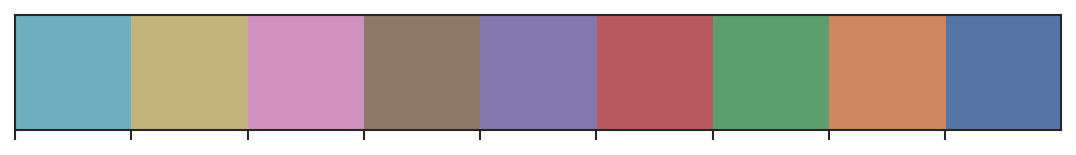

In [98]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 0.8)
colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
#plt.rcParams['axes.grid.axis'] = 'y'
#plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-v0_8')

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [99]:
def read_wave(file_path, resolution=np.int32):
    with wave.open(file_path, 'r') as wf:
        # Extract audio data
        n_frames = wf.getnframes()
        n_channels = wf.getnchannels()
        sample_width = wf.getsampwidth()
        sample_rate = wf.getframerate()

        

        # Read frames and convert to numpy array
        frames = wf.readframes(n_frames)
        signal = np.frombuffer(frames, dtype=resolution) 
        signal = signal/np.max(np.abs(signal))
        signal = abs(signal)

        # If stereo, take only one channel
        if n_channels > 1:
            signal = signal[::n_channels]

        # Create time array
        time = np.linspace(0, n_frames / sample_rate, num=len(signal))
        

    return signal, sample_rate, time

@numba.njit(fastmath=True)
def signal_avg(signal, time, step):
    new_signal = []
    new_time = time[::step] 

    i = 0
    while i < len(signal):
        if i+10 < len(signal):
            new_signal.append(np.mean(signal[i:i+step]))
            i += step
        else:
            new_signal.append(np.mean(signal[i:]))
            i += step

    return new_time, new_signal

@numba.njit(fastmath=True)
def lin_fit(x, a, b):
    return a*x + b

@numba.njit(fastmath=True)
def p_func(x_list, threshold_l, threshold_h):

    p = np.zeros(len(x_list))

    for i in range(len(x_list)): 
        if i <= threshold_l:
            p[i] = 1
        elif i > threshold_l and i <= threshold_h:
            p[i] = 1/2 * (1 + np.cos(np.pi * (i - threshold_l) / (threshold_h - threshold_l + 1)))
        else:
            p[i] = 0 
        
    return p

@numba.njit(fastmath=True)
def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i


### Functions for signal smoothing ###

def running_mean(t, s, neigh):
    r_mean_s = []
    r_mean_t = []
    start_i = neigh
    for i in range(len(s) - neigh):
        i_col = i + start_i
        r_mean_s.append(np.mean(s[i:i_col+neigh]))
        r_mean_t.append(t[i_col])
    
    return np.array(r_mean_s), np.array(r_mean_t)

def lp_filter(signal, cutoff_frequency=100, sampling_rate=44100, filter_order=2):
    nyquist = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist
    b, a = butter(filter_order, normalized_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)



### Processing and grouping data ###

def synchro(met_tuple, exp_tuple):
    ### THIS ASSUMES THAT PARTICIPANTS CLAP AT THE FIRST BEEP OF THE METRONOME ### 

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    s_met = np.array(s_met)
    s_exp = np.array(s_exp)
    t_met = np.array(t_met)
    t_exp = np.array(t_exp)


    min_val_met = min(f_met)
    min_index_met = np.where(f_met == min_val_met)[0][0]

    min_val_exp = min(f_exp)
    min_index_exp = np.where(f_exp == min_val_exp)[0][0]
    
    # Masking peak data of metronome
    mask_met = pt_met >= ft_met[min_index_met]
    mask_exp = pt_exp >= ft_exp[min_index_exp]
    

    first_met_pt = pt_met[mask_met][0]
    first_exp_pt = pt_exp[mask_exp][0]
    mask_met_t = t_met >= first_met_pt
    mask_exp_t = t_exp >= first_exp_pt
    mask_met_f = ft_met > first_met_pt
    mask_exp_f = ft_exp > first_exp_pt

    # Adjusting signal and times
    t_met = t_met[mask_met_t]
    s_met = s_met[mask_met_t]
    t_met = t_met - t_met[0]

    # Adjusting peaks and peak-times
    pt_met = pt_met[mask_met]
    p_met = p_met[mask_met]
    pt_met = pt_met - pt_met[0]


    # Adjusting signal and time
    t_exp = t_exp[mask_exp_t]
    s_exp = s_exp[mask_exp_t]
    t_exp = t_exp - t_exp[0]

    # Adjusting peaks and peak-times
    pt_exp = pt_exp[mask_exp]
    p_exp = p_exp[mask_exp]
    pt_exp = pt_exp - pt_exp[0]


    # Adjusting the frequency data
    f_met = 1/np.diff(pt_met)
    ft_met = pt_met[1:]
    f_exp = 1/np.diff(pt_exp)
    ft_exp = pt_exp[1:]
    

    ## Cutting off a desired number of claps
    #ft_exp = ft_exp[cut:]
    #f_exp = f_exp[cut:]
    #ft_met = ft_met[cut:]
    #f_met = f_met[cut:]

    ## Synchronizing the two signals at the first data point
    #diff = ft_exp[0] - ft_met[0]
    #ft_exp = ft_exp - diff


    re_met_tuple = t_met, s_met, pt_met, p_met, ft_met, f_met
    re_exp_tuple = t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp
    
    return re_met_tuple, re_exp_tuple

def avg_calc(met_tuple, exp_tuple):

    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple
    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple 

    # Calculating bin edges for time intervals to take the average of the peak times in
    bin_edges = (pt_met[:-1] + pt_met[1:])/2

    # Add start and end point
    start_diff = bin_edges[1] - bin_edges[0]
    end_diff = bin_edges[-1] - bin_edges[-2]
    bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))

    fail = 0

    avg_val = []
    std_val = []

    for i in range(len(bin_edges) - 1):
        mask = (pt_exp > bin_edges[i]) & (pt_exp < bin_edges[i+1])
        masked_data = pt_exp[mask]
        if len(masked_data) > 0:
            avg = np.mean(masked_data)
            std = np.std(masked_data)
            avg_val.append(avg)
            std_val.append(std)

        else:
            fail += 1
            continue

    avg_val = np.array(avg_val)
    avg_per = avg_val[1:] - avg_val[:-1]
    avg_freq = 1/avg_per


    t_err = []
    for i in range(len(std_val)-1):
        t_err_i = np.sqrt(std_val[i]**2 + std_val[i+1]**2)
        t_err.append(t_err_i)

    freq_err = []

    for i in range(len(t_err)): 
        freq_err_i = np.sqrt(1/avg_per[i]**2 * t_err[i]**2)
        freq_err.append(freq_err_i)


    return avg_freq, freq_err, avg_per, fail, avg_val #, avg_std


def deviation_func(data_list, thr_l, thr_h): 
    data_met_dev = []
    start_dev_list = []
    trans_dev_list = []
    end_dev_list = []

    time_dev_list = []
    time_start_dev_list = []
    time_trans_dev_list = []
    time_end_dev_list = []
    

    for i in range(len(data_list)):
        
        #print(len(data_list[i][0]), len(data_list[i][2]))
        deviation = ((data_list[i][0] - data_list[i][2]))
        dev_start = np.abs(deviation[:thr_l])
        dev_trans = np.abs(deviation[thr_l : thr_h])
        dev_end = np.abs(deviation[thr_h:])


        data_met_dev.append(deviation)
        start_dev_list.append(np.mean(dev_start))
        trans_dev_list.append(np.mean(dev_trans))
        end_dev_list.append(np.mean(dev_end))

        time_dev = data_list[i][10][1:]- data_list[i][8][1:]
        time_dev_list.append(time_dev)
        time_start_dev_list.append(np.mean(time_dev[:thr_l])) 
        time_trans_dev_list.append(np.mean(time_dev[thr_l:thr_h]))
        time_end_dev_list.append(np.mean(time_dev[thr_h:]))
                                   
                                   


    dev_tuple = (data_met_dev, start_dev_list, trans_dev_list, end_dev_list, time_dev_list, time_start_dev_list, time_trans_dev_list, time_end_dev_list)

    return dev_tuple

def deviation_plot(data_list, dev_tuple, thr_l=24, thr_h=40, max_beats=56):

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
    ax = ax.flatten()
    
    # Metronome bpm values
    low = 80
    mid = 120
    high = 160
    bpm_list = [(low, mid), (low, high), (mid, low), (mid, high), (high, low), (high, mid)]

    counter = 0

    props = dict(boxstyle='round', facecolor='white', edgecolor = 'k', alpha=0.7, pad = 0.5)

    for i in range(len(ax)):
        if i % 4 != 0:

            low_cap =  thr_l / (bpm_list[counter][0] / 60 )
            high_cap = (max_beats - thr_h) / (bpm_list[counter][1] / 60 )
            


            name = met_filenames[counter].split('_')
            finished_name = ''
            for n in name:
                n = n.upper()
                finished_name += n + ' to '

            finished_name = finished_name[:-3]
            


            ax[i].plot(data_list[counter][3], dev_tuple[0][counter], marker='.', ls='')
            ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta f$ [Hz]'))
            ax[i].set_title(finished_name)
            ax[i].set_ylim(-0.55,0.55)


            # Color blocking
            ax[i].axvspan(0, low_cap, color='green', alpha=0.1)
            #ax[i].axvspan(low_cap, high_cap, color='yellow', alpha=0.1)
            ax[i].axvspan(data_list[counter][3][-1] - high_cap, data_list[counter][3][-1], color='red', alpha=0.1)

            # adding box with different deviations 
            textstr = '\n'.join((
                r'$\Delta f_{start}=%.2f$' % (dev_tuple[1][counter]),
                r'$\Delta f_{trans}=%.2f$' % (dev_tuple[2][counter]),
                r'$\Delta f_{end}=%.2f$' % (dev_tuple[3][counter])))

            ax[i].text(0.38, 0.75, textstr, transform=ax[i].transAxes, fontsize=8, bbox=props)

            counter += 1

        else: 
            ax[i].set_visible(False)

    fig.tight_layout()
    #plt.show() 

    return fig, ax



### Data extract using low-pass filter (fast) ###
def data_extract_lp(file, resolution, cutoff_frequency, height_var, prominence_var):
    signal, sample_rate, time = read_wave(file, resolution)

    ### LOW-PASS FILTER (FAST) ###
    signal = lp_filter(signal, cutoff_frequency)


    peak_indicies = sc.signal.find_peaks(signal, height=height_var, prominence=prominence_var)[0]
    peak_times = time[peak_indicies]
    peaks = signal[peak_indicies]

    #peak_times, peaks = peak_finder_neigh(time, signal, neigh_peak, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list

### Data extract using running mean (slow) ###
def data_extract_rm(file, resolution, neigh_rm, height_var, prominence_var):
    signal, sample_rate, time = read_wave(file, resolution)
    
    ### RUNNING MEAN (SLOW) ###
    signal, time = running_mean(time, signal, neigh_rm)


    peak_indicies = sc.signal.find_peaks(signal, height=height_var, prominence=prominence_var)[0]
    peak_times = time[peak_indicies]
    peaks = signal[peak_indicies]

    #peak_times, peaks = peak_finder_neigh(time, signal, neigh_peak, threshold)

    freq_list = 1/np.diff(peak_times)
    freq_tlist = peak_times[1:]

    return time, signal, peak_times, peaks, freq_tlist, freq_list


### Quick extraction of data using low-pass filter ###
def final_data_lp_added(
                  filename1, 
                  filename2, 
                  resolution=(np.int16, np.int16), 
                  cutoff_frequency=(100, 100), 
                  height=(0.05, 0.05), 
                  prominence=(0.1, 0.1)
                  ):
    
    met_tuple = data_extract_lp(f'lydfiler/metronomfiler/{filename1}.wav', 
                                resolution[0], 
                                cutoff_frequency[0], 
                                height[0], 
                                prominence[0])
    

    exp_tuple = data_extract_lp(f'lydfiler/{filename2}.wav', 
                                resolution[1], 
                                cutoff_frequency[1], 
                                height[1], 
                                prominence[1])

    met_tuple, exp_tuple = synchro(met_tuple, exp_tuple)
    avg_freq, freq_err, avg_per, fail, avg_val = avg_calc(met_tuple, exp_tuple)

    if fail > 0:
        print(fail)
        print(filename2)
        

    t_exp, s_exp, pt_exp, p_exp, ft_exp, f_exp = exp_tuple
    t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple

    x = np.cumsum(avg_per)

    return avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp, pt_met, p_met, avg_val

### Quick extraction of experimental data using lp-filter ###
def experiment_data_ext(file_extensions, res, cts, height_met, height_exp, prom_met, prom_exp):
    exp_data_list = []
    ct_met, ct_exp = cts

    standard_filenames = ['lm_n', 'lh_n', 'ml_n', 'mh_n', 'hl_n', 'hm_n']
    standard_met_filenames = ['low_mid', 'low_high', 'mid_low', 'mid_high', 'high_low', 'high_mid']

    met_filenames = [standard_met_filenames[i] + '_inc_thres' for i in range(len(standard_met_filenames))]

    exp_filenames = [str(file_extensions[0]) + standard_filenames[i] + str(file_extensions[1]) for i in range(len(standard_filenames))]

    for i, name in enumerate(exp_filenames):
        synced_data = final_data_lp_added(met_filenames[i], 
                                     name, 
                                     resolution=res, 
                                     cutoff_frequency=(ct_met, ct_exp), 
                                     height=(height_met[i], height_exp[i]), 
                                     prominence=(prom_met[i], prom_exp[i]))
        

        exp_data_list.append(synced_data)

    return exp_data_list

### Plotting quick-extracted data ###
def exp_data_plot_func(data_list):
    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)


    counter = 0
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):

            ### Defining metronome values ###
            if i != j:

                low = 80
                mid = 120
                high = 160

                # 3x3 bpm matrix
                bpm = np.array([[(low, low), (low, mid), (low, high)],
                                [(mid, low), (mid, mid), (mid, high)],
                                [(high, low), (high, mid), (high, high)]])
                # set diag = 0
                for k in range(3):
                    bpm[k,k] = (0, 0)
                
                threshold_l = 24
                threshold_h = 48

            #################################

            
            ### Calculating sigmoid function ###
                sig_x = np.linspace(data_list[counter][3][0], data_list[counter][3][-1], len(data_list[counter][3]))
                p_list = p_func(sig_x, threshold_l, threshold_h)
                sig_y = 1 / interval_calc(*bpm[i,j], p_list)

            ###################################

                name = met_filenames[counter].split('_')
                finished_name = ''
                for n in name:
                    n = n.upper()
                    finished_name += n + ' to '

                finished_name = finished_name[:-3]
        

            ### Plotting data ###
                ax[i,j].errorbar(data_list[counter][3], data_list[counter][0], yerr=data_list[counter][1], marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
                ax[i,j].plot(data_list[counter][3], data_list[counter][2], marker='.', ls='', color='red', alpha=0.5)
                ax[i,j].set(xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
                ax[i,j].set_title(finished_name)
                ax[i,j].plot(data_list[counter][3], sig_y, ls='--', marker='', linewidth=0.8, color='k', alpha=1)

                counter += 1
            else: 
                ax[i,j].set_visible(False)

            ###################################


    fig.tight_layout()
    plt.show()

    return fig, ax


def time_deviation_plot(data_list, dev_tuple, thr_l=24, thr_h=40, max_beats=56):

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
    ax = ax.flatten()
    
    # Metronome bpm values
    low = 80
    mid = 120
    high = 160
    bpm_list = [(low, mid), (low, high), (mid, low), (mid, high), (high, low), (high, mid)]

    counter = 0

    props = dict(boxstyle='round', facecolor='white', edgecolor = 'k', alpha=0.7, pad = 0.5)

    for i in range(len(ax)):
        if i % 4 != 0:

            low_cap =  thr_l / (bpm_list[counter][0] / 60 )
            high_cap = (max_beats - thr_h) / (bpm_list[counter][1] / 60 )
            


            name = met_filenames[counter].split('_')
            finished_name = ''
            for n in name:
                n = n.upper()
                finished_name += n + ' to '

            finished_name = finished_name[:-3]
            

            ax[i].plot(data_list[counter][3], dev_tuple[4][counter], marker='.', ls='')
            ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta t$ [s]'))
            ax[i].set_title(finished_name)
            ax[i].set_ylim(-0.55,0.55)


            # Color blocking
            ax[i].axvspan(0, low_cap, color='green', alpha=0.1)
            #ax[i].axvspan(low_cap, high_cap, color='yellow', alpha=0.1)
            ax[i].axvspan(data_list[counter][3][-1] - high_cap, data_list[counter][3][-1], color='red', alpha=0.1)

            # adding box with different deviations 
            textstr = '\n'.join((
                r'$\Delta t_{start}=%.2f$' % (dev_tuple[5][counter]),
                r'$\Delta t_{trans}=%.2f$' % (dev_tuple[6][counter]),
                r'$\Delta t_{end}=%.2f$' % (dev_tuple[7][counter])))

            ax[i].text(0.38, 0.75, textstr, transform=ax[i].transAxes, fontsize=8, bbox=props)

            counter += 1

        else: 
            ax[i].set_visible(False)

    fig.tight_layout()
    #plt.show() 

    return fig, ax

In [100]:
read_wave('lydfiler/metronomfiler/low_high.wav', resolution=np.int32)[1]

44100

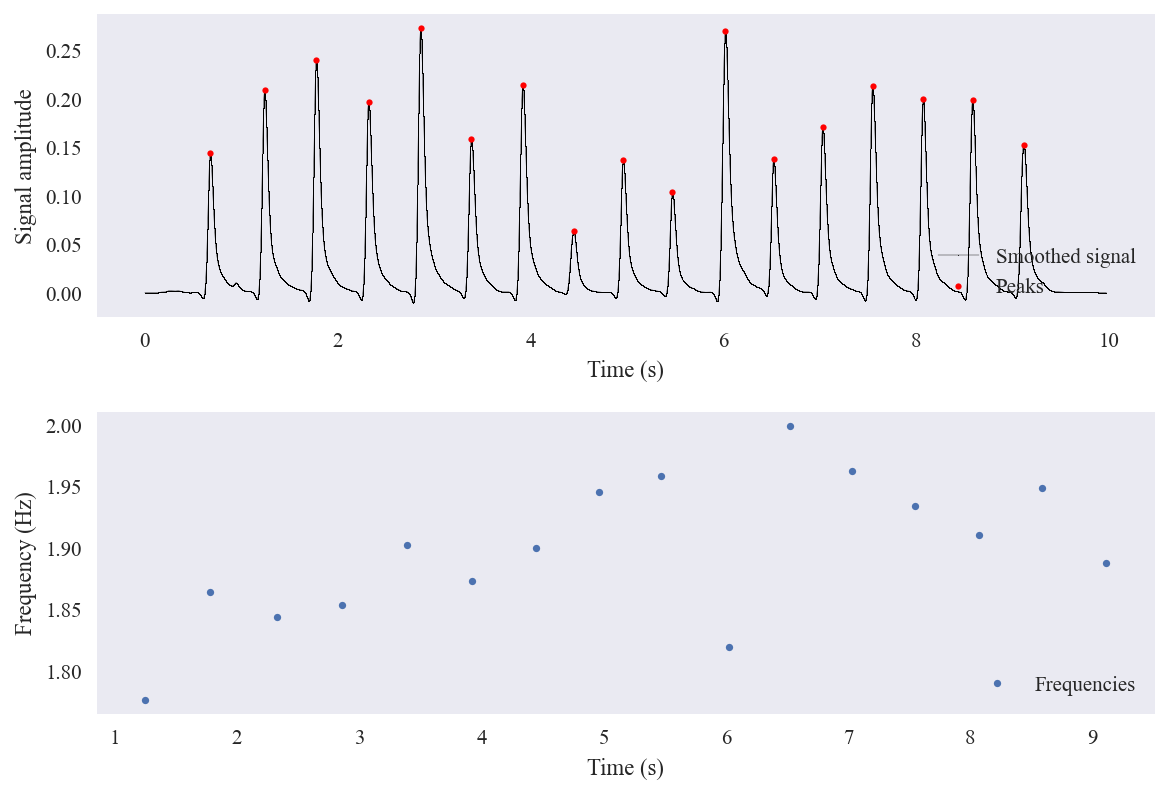

In [101]:
new_time, new_signal, peak_times, peaks, freq_tlist, freq_list = data_extract_lp('trial.wav',
                                                                                   resolution=np.int32, 
                                                                                   cutoff_frequency=10, 
                                                                                   height_var=0.05,
                                                                                   prominence_var=0.02)

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(new_time, 
           new_signal, 
           color='black', 
           ls='-', 
           marker='.', 
           linewidth = 0.2, 
           markersize=0.8, 
           label='Smoothed signal')


ax[0].plot(peak_times, peaks, color='red', ls='', marker='o', markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].legend(loc='lower right')
#ax[0].set_xlim(5.9,6.1)

ax[1].plot(freq_tlist, freq_list, '.', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

Sigrid and Niels clapping to the low mid metronome 

In [102]:
ns_tuple_lm = data_extract_lp('lydfiler/Niels_Sigrid/Niels_og_Sigrid.wav', 
                               resolution=np.int32, 
                               cutoff_frequency=100, 
                               height_var=0.05,
                               prominence_var=0.001)

met_tuple_lm = data_extract_lp('lydfiler/metronomfiler/low_mid.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.05,
                                prominence_var=0.01)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_tuple_lm
t_ns, s_ns, pt_ns, p_ns, ft_ns, f_ns = ns_tuple_lm

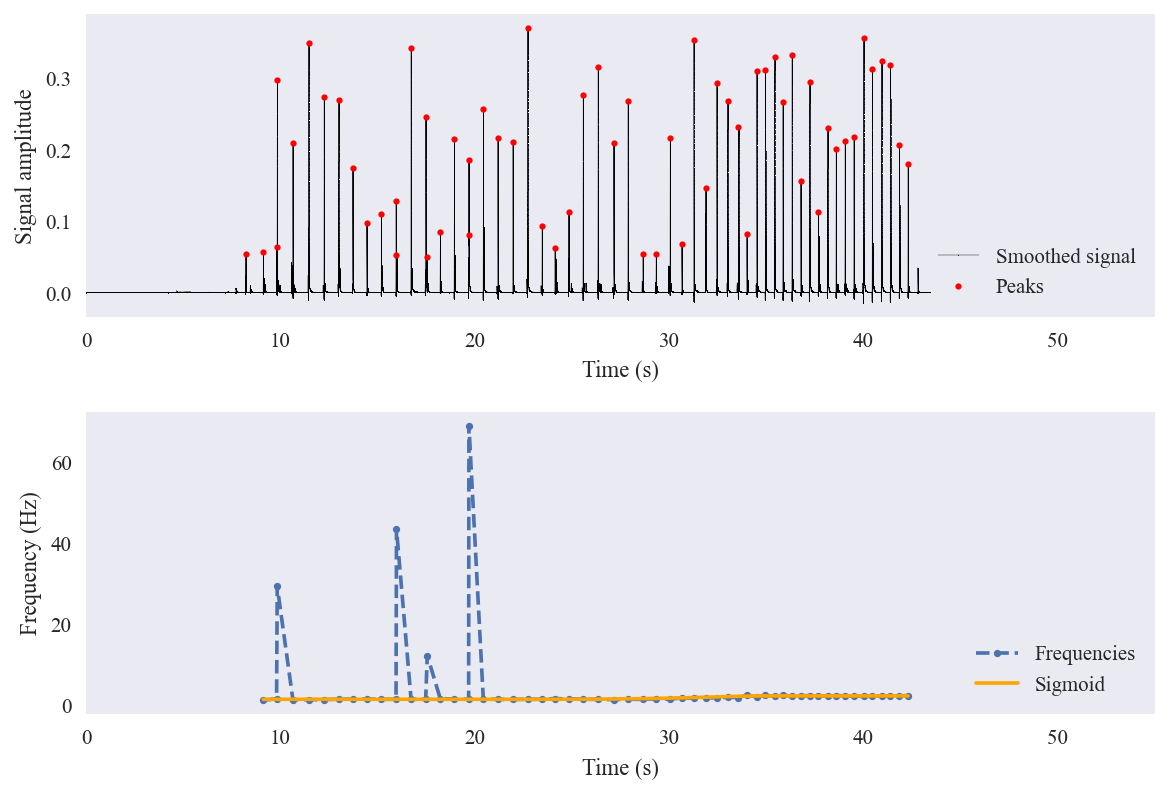

In [103]:
sig_x = np.linspace(9, ft_ns[-1], len(ft_ns))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)


fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(t_ns, s_ns, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Smoothed signal')
ax[0].plot(pt_ns, p_ns, color='red', ls='', marker='o', linewidth = 0.2, markersize=3, label='Peaks')
ax[0].grid()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')
ax[0].set_xlim(0,55)
ax[0].legend(loc='lower right')

ax[1].plot(ft_ns, f_ns, '.--', label='Frequencies')
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlim(0,55)
ax[1].plot(ft_ns, sig_y, c='orange', label = 'Sigmoid')
ax[1].legend(loc='lower right')

fig.tight_layout()

Synchronised data for Niels and Sigrid clapping to the low mid metronome

In [104]:
cut = 0
met_tuple_lm, ns_tuple_lm = synchro(met_tuple_lm, ns_tuple_lm)

t_met_lm, s_met_lm, pt_met_lm, p_met_lm, ft_met_lm, f_met_lm = met_tuple_lm
t_ns_lm, s_ns_lm, pt_ns_lm, p_ns_lm, ft_ns_lm, f_ns_lm = ns_tuple_lm


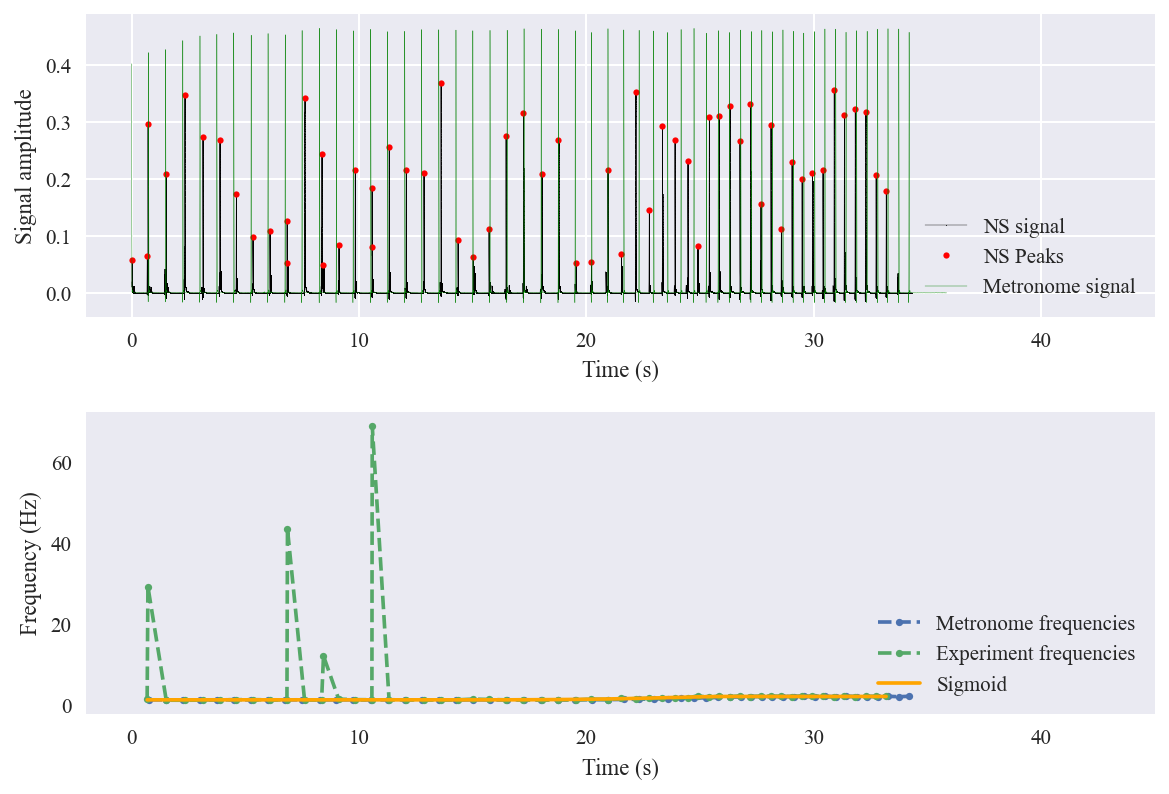

In [105]:
sig_x = np.linspace(0, ft_ns_lm[-1], len(ft_ns_lm))
p_list = p_func(sig_x, threshold_l = 24, threshold_h = 40)
sig_y = 1 / interval_calc(80,130, p_list)

fig, ax = plt.subplots(2,1, dpi=150)

ax[0].plot(t_ns_lm, s_ns_lm, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax[0].plot(pt_ns_lm, p_ns_lm, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
#ax[0]].plot(pt_met_lm, p_met_lm, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax[0].plot(t_met_lm, s_met_lm, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax[0].legend(loc='lower right')
ax[0].set_xlim(-2,45)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Signal amplitude')

ax[1].plot(ft_met_lm, f_met_lm, '.--', label='Metronome frequencies')
ax[1].plot(ft_ns_lm, f_ns_lm, '.--', label='Experiment frequencies')
ax[1].plot(ft_ns_lm, sig_y, c='orange', label = 'Sigmoid')
ax[1].set_xlim(-2,45)
ax[1].grid()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].legend(loc='lower right')

fig.tight_layout()

### Fixing Gefion 3y data

_____

In [106]:
n9_hl = data_extract_lp('lydfiler/3y/hl_n9.wav', 
                               resolution=np.int16, 
                               cutoff_frequency=100, 
                               height_var=0.025,
                               prominence_var=0.02)

met_hl = data_extract_lp('lydfiler/metronomfiler/high_low_inc_thres.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.07,
                                prominence_var=0.3)


In [107]:
cut = 0
#met_hl, n9_hl = synchro(met_hl, n9_hl)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_hl
t_n9, s_n9, pt_n9, p_n9, ft_n9, f_n9 = n9_hl

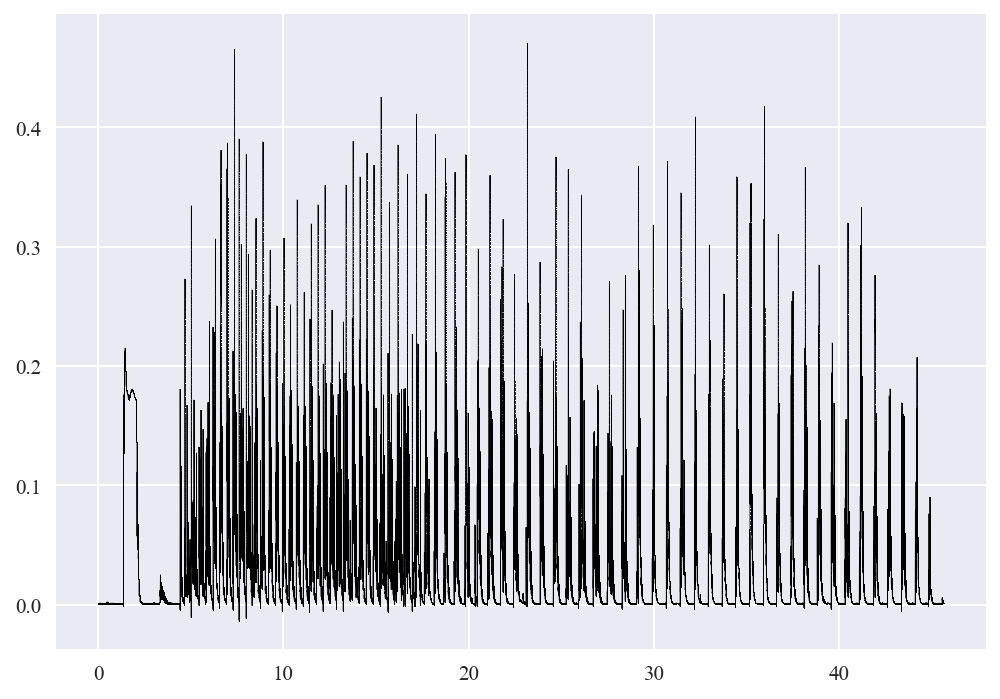

In [108]:
fig, ax = plt.subplots(dpi=150)

ax.plot(t_n9, s_n9, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')

____

# Trying data analysis on data from Sigrids family

In [109]:
### SETUP FOR LOADING ALL DATA FROM SIGRIDS FAMILY ###

filenames = ['Sigrids_familie/low_mid_fam', 'Sigrids_familie/low_high_fam',
             'Sigrids_familie/mid_low_fam', 'Sigrids_familie/mid_high_fam',
             'Sigrids_familie/high_low_fam', 'Sigrids_familie/high_mid_fam']


met_filenames = ['low_mid', 'low_high',
                 'mid_low', 'mid_high',
                 'high_low', 'high_mid']



fam_list = []
for i, name in enumerate(filenames):
    synced_data = final_data_lp_added(met_filenames[i], 
                                 name, 
                                 resolution=(np.int16, np.int16), 
                                 cutoff_frequency=(100, 100), 
                                 height=(0.05, 0.05), 
                                 prominence=(0.01, 0.01))
    
    fam_list.append(synced_data)

low = 80
mid = 130
high = 180

max_beats = 56
threshold_l = 24
threshold_h = 40

# 3x3 bpm matrix
bpm = np.array([[(low, low), (low, mid), (low, high)],
                [(mid, low), (mid, mid), (mid, high)],
                [(high, low), (high, mid), (high, high)]])
# set diag = 0
for i in range(3):
    bpm[i,i] = (0, 0)



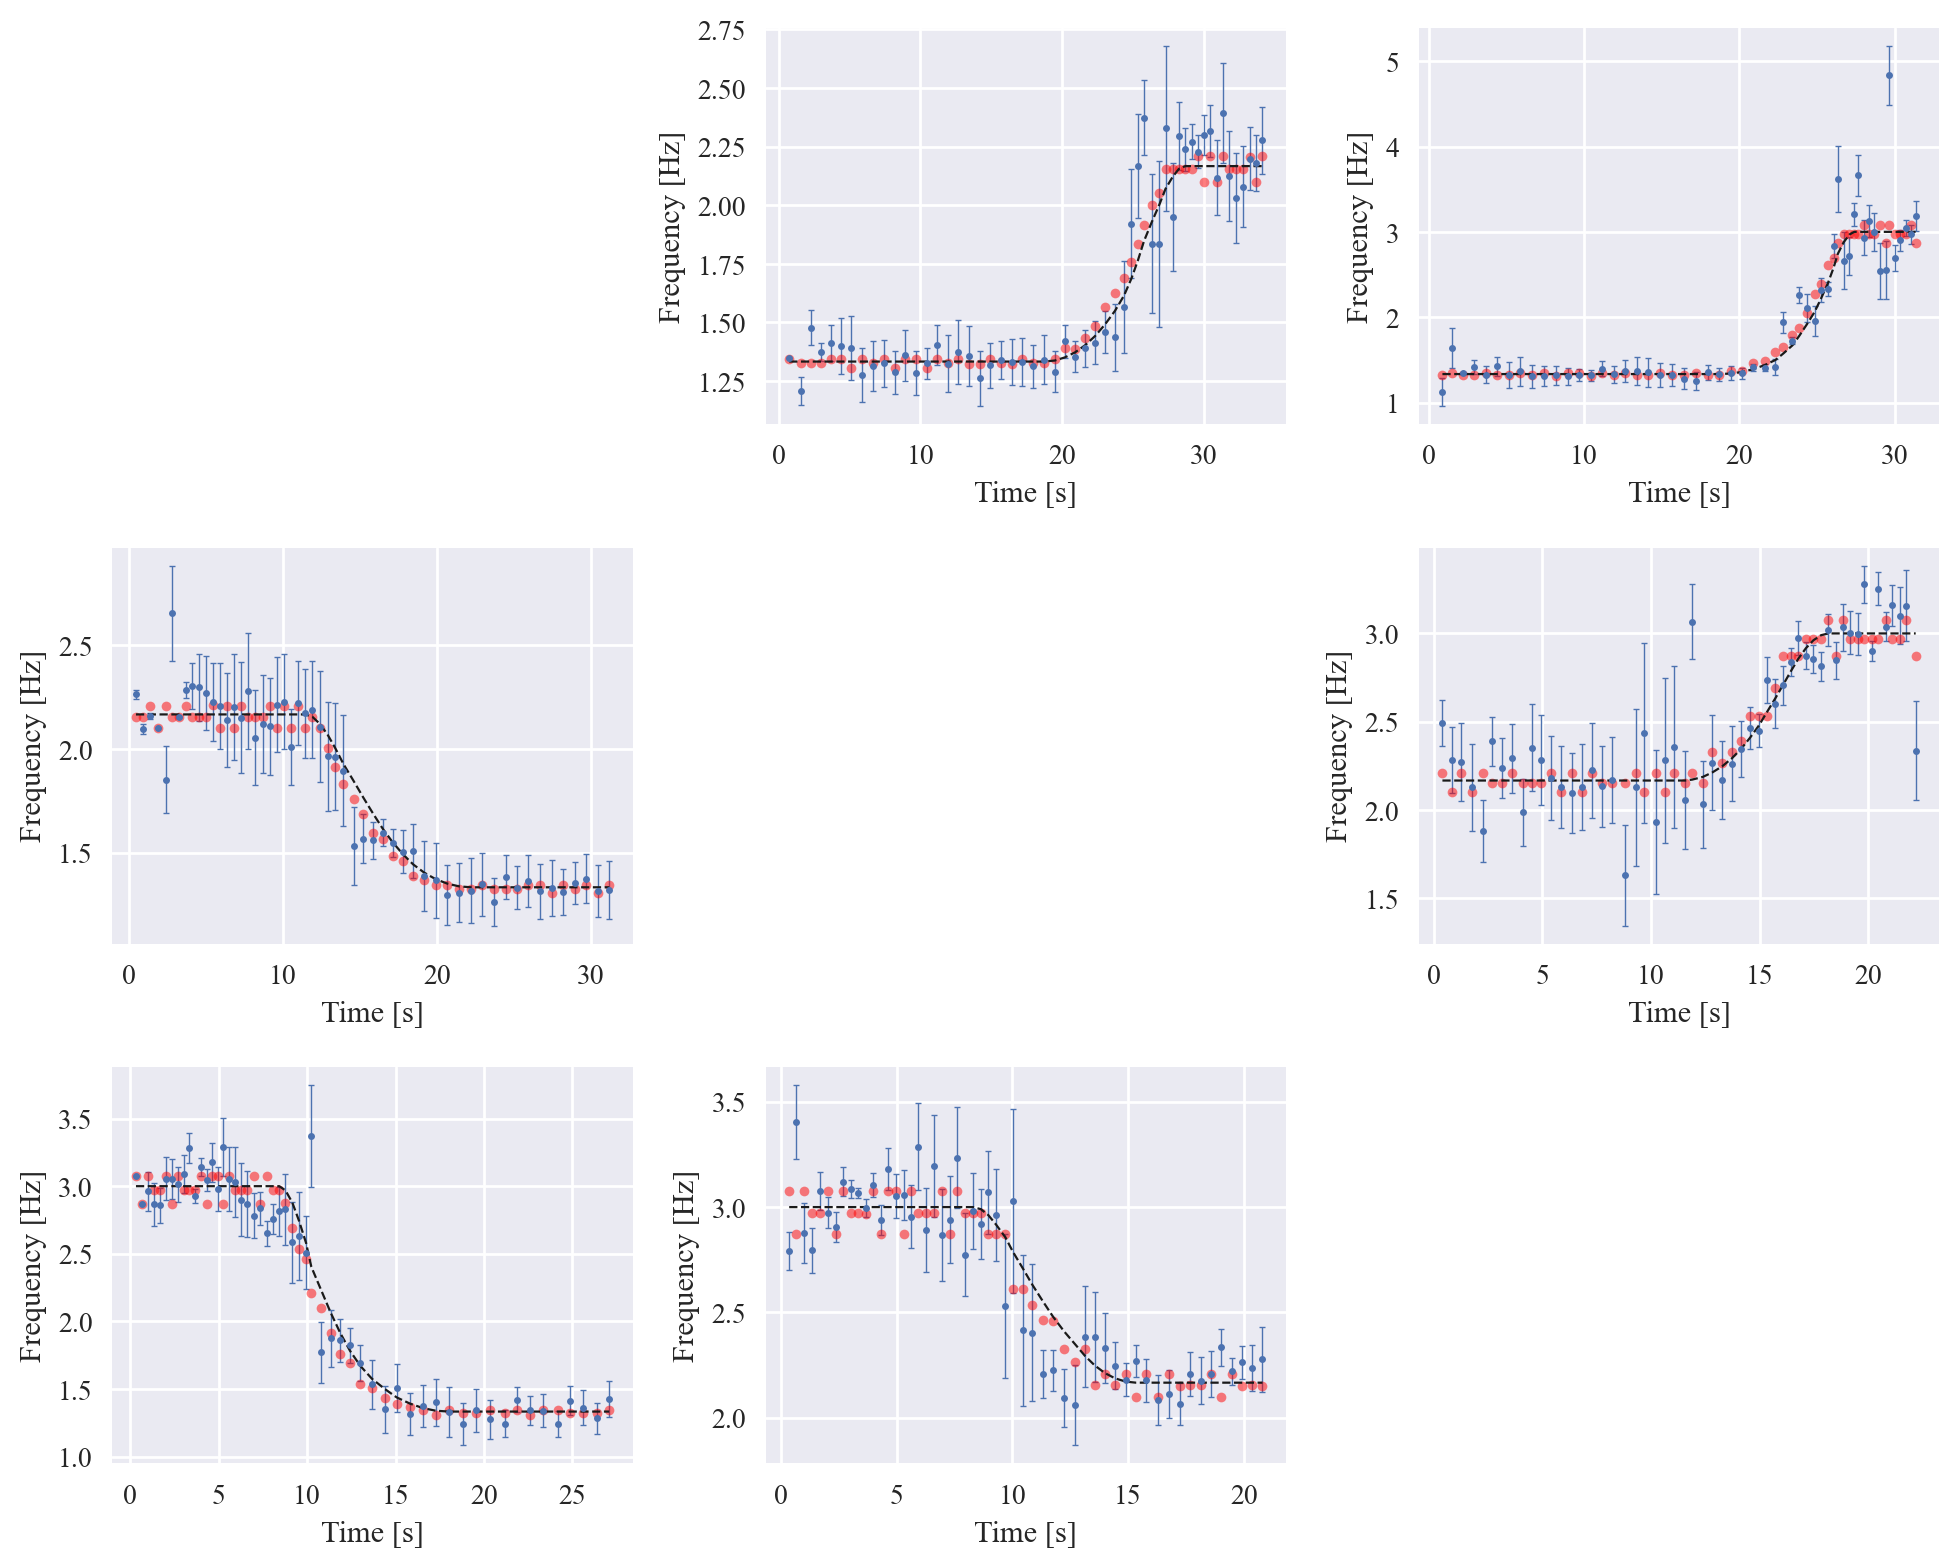

In [110]:
fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)


counter = 0
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if i != j:

            sig_x = np.linspace(0, fam_list[counter][3][-1], len(fam_list[counter][3]))
            p_list = p_func(sig_x, threshold_l, threshold_h)
            sig_y = 1 / interval_calc(*bpm[i,j], p_list)

            ax[i,j].errorbar(fam_list[counter][3], fam_list[counter][0], yerr=fam_list[counter][1], marker='.', ls='', elinewidth=0.5, markersize=5, capsize=1, capthick=0.5)
            ax[i,j].plot(fam_list[counter][3], fam_list[counter][2], marker='.', ls='', color='red', alpha=0.5)
            ax[i,j].set(xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))
            ax[i,j].plot(fam_list[counter][3], sig_y, ls='--', marker='', linewidth=0.8, color='k', alpha=1)

            counter += 1
        else: 
            ax[i,j].set_visible(False)
        

fig.tight_layout()
plt.show()


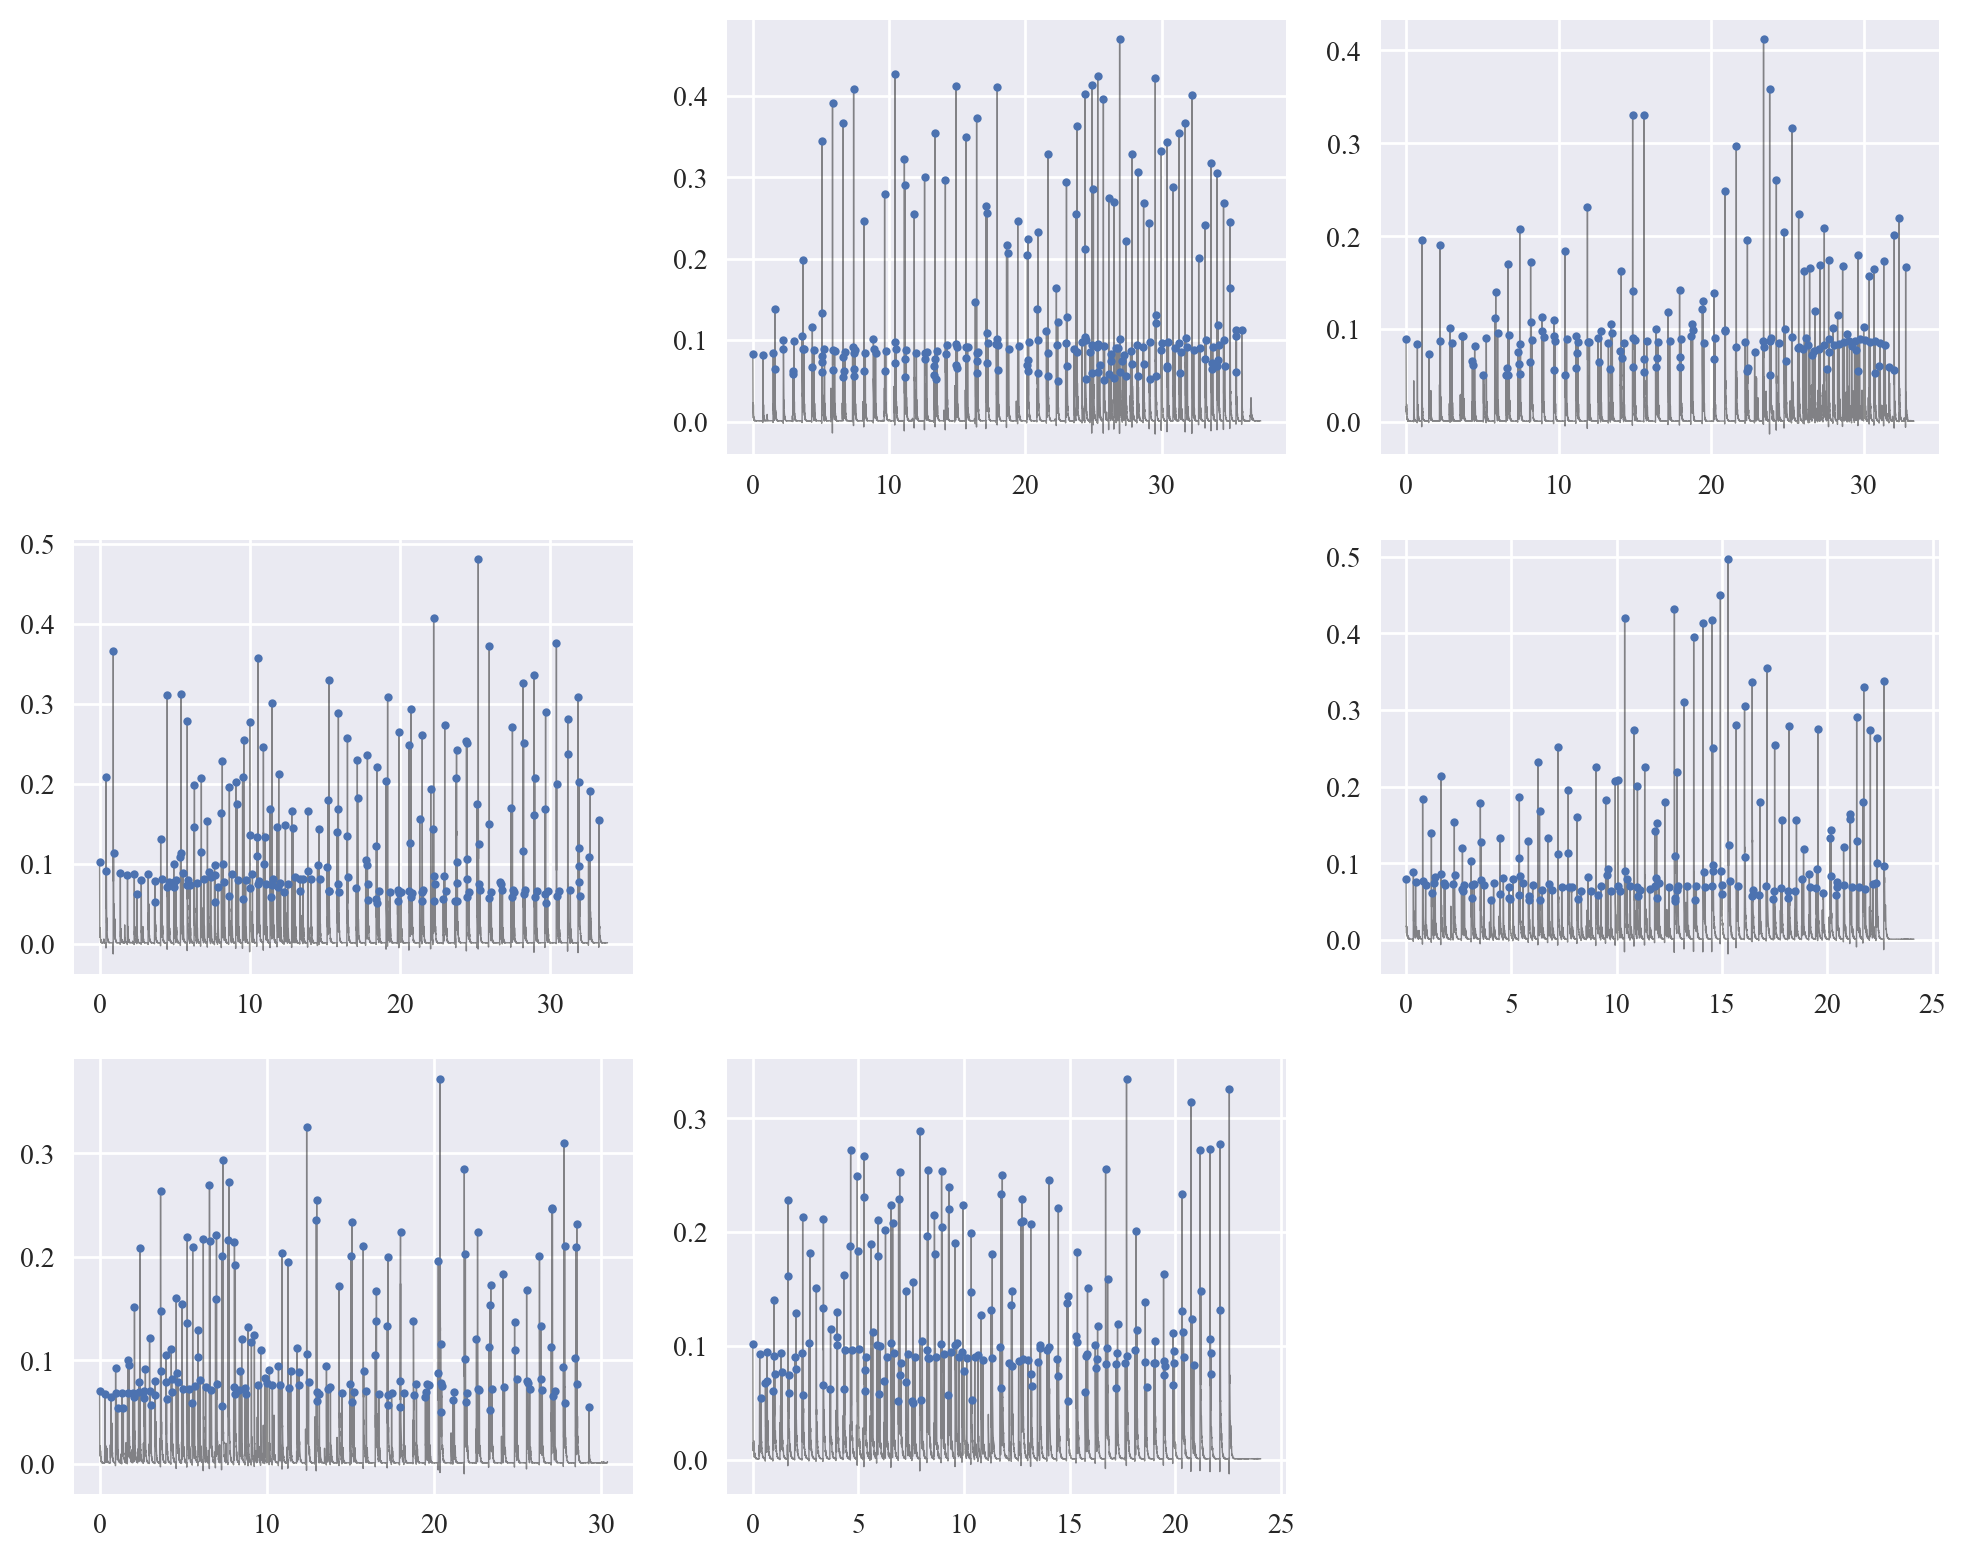

In [111]:
### Plotting signals with peaks ###

fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
ax = ax.flatten()

counter = 0
for i in range(len(ax)):
    if i % 4 != 0:
    
        ax[i].plot(fam_list[counter][4], fam_list[counter][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
        ax[i].plot(fam_list[counter][6], fam_list[counter][7], marker = 'o', markersize = 3, ls = '')
        #ax[i].set(ylim=(0.8, 5), xlabel = ('Time [s]'), ylabel = ('Frequency [Hz]'))

        counter += 1
    else: 
        ax[i].set_visible(False)

fig.tight_layout()
plt.show()


In [112]:
mh_tuple = final_data_lp_added('mid_high', 
                   'Sigrids_familie/mid_high_fam', 
                   resolution=(np.int16, np.int16),
                   prominence=(0.01, 0.01))


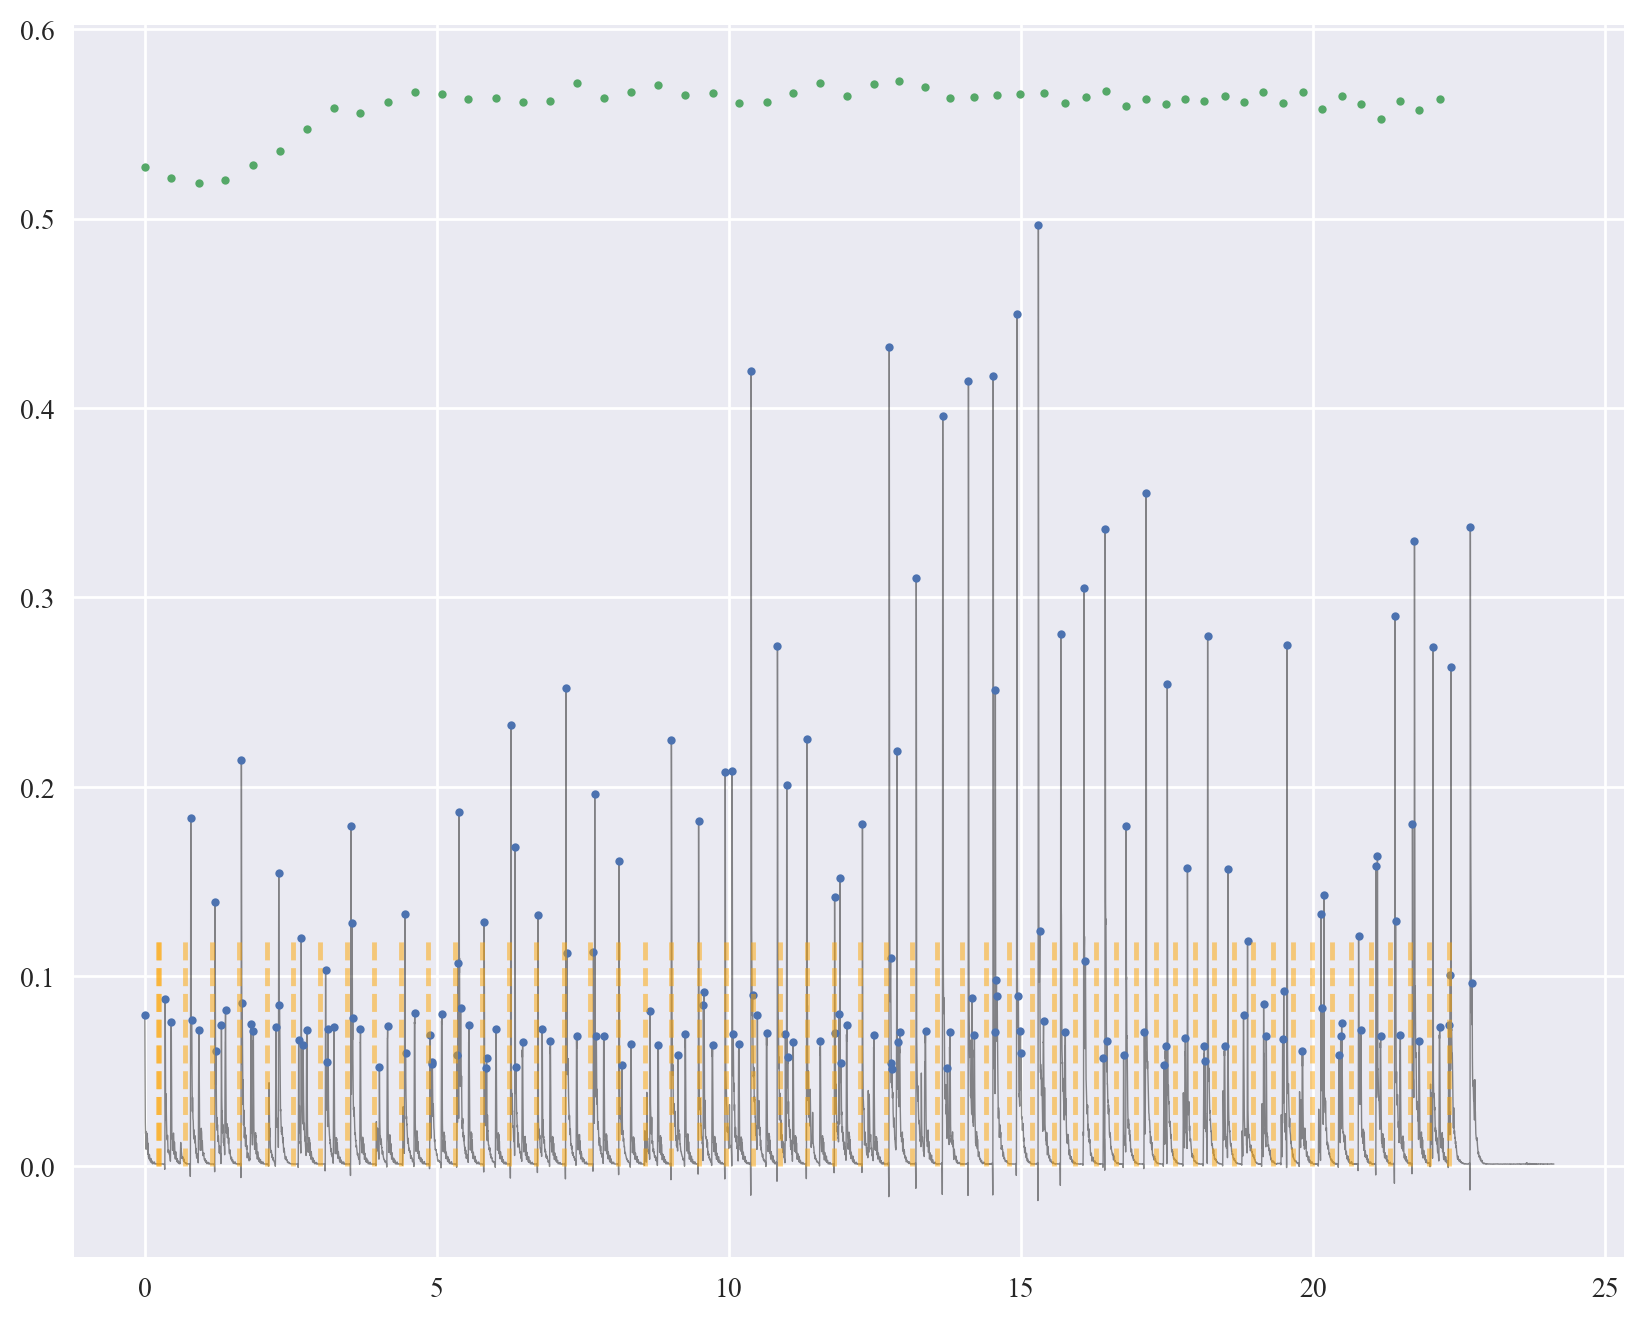

In [113]:
### Checking peaks and signal for a single file ###

mh_pt_met = mh_tuple[8]
bin_edges = (mh_pt_met[:-1] + mh_pt_met[1:])/2
bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=((bin_edges[1] - 2 * bin_edges[0]), 2 * bin_edges[-1] - bin_edges[-2]))
zeroes = np.zeros(len(bin_edges))

fig, ax = plt.subplots(figsize=(10,8), dpi=200)
ax.plot(fam_list[3][4], fam_list[3][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
ax.plot(fam_list[3][6], fam_list[3][7], marker = 'o', markersize = 3, ls = '')
# Plot metronone peak times
ax.plot(mh_pt_met, mh_tuple[9], marker='o', markersize=3, ls='')
ax.vlines(bin_edges, 0, 0.12, ls='--', color='orange', alpha=0.5)




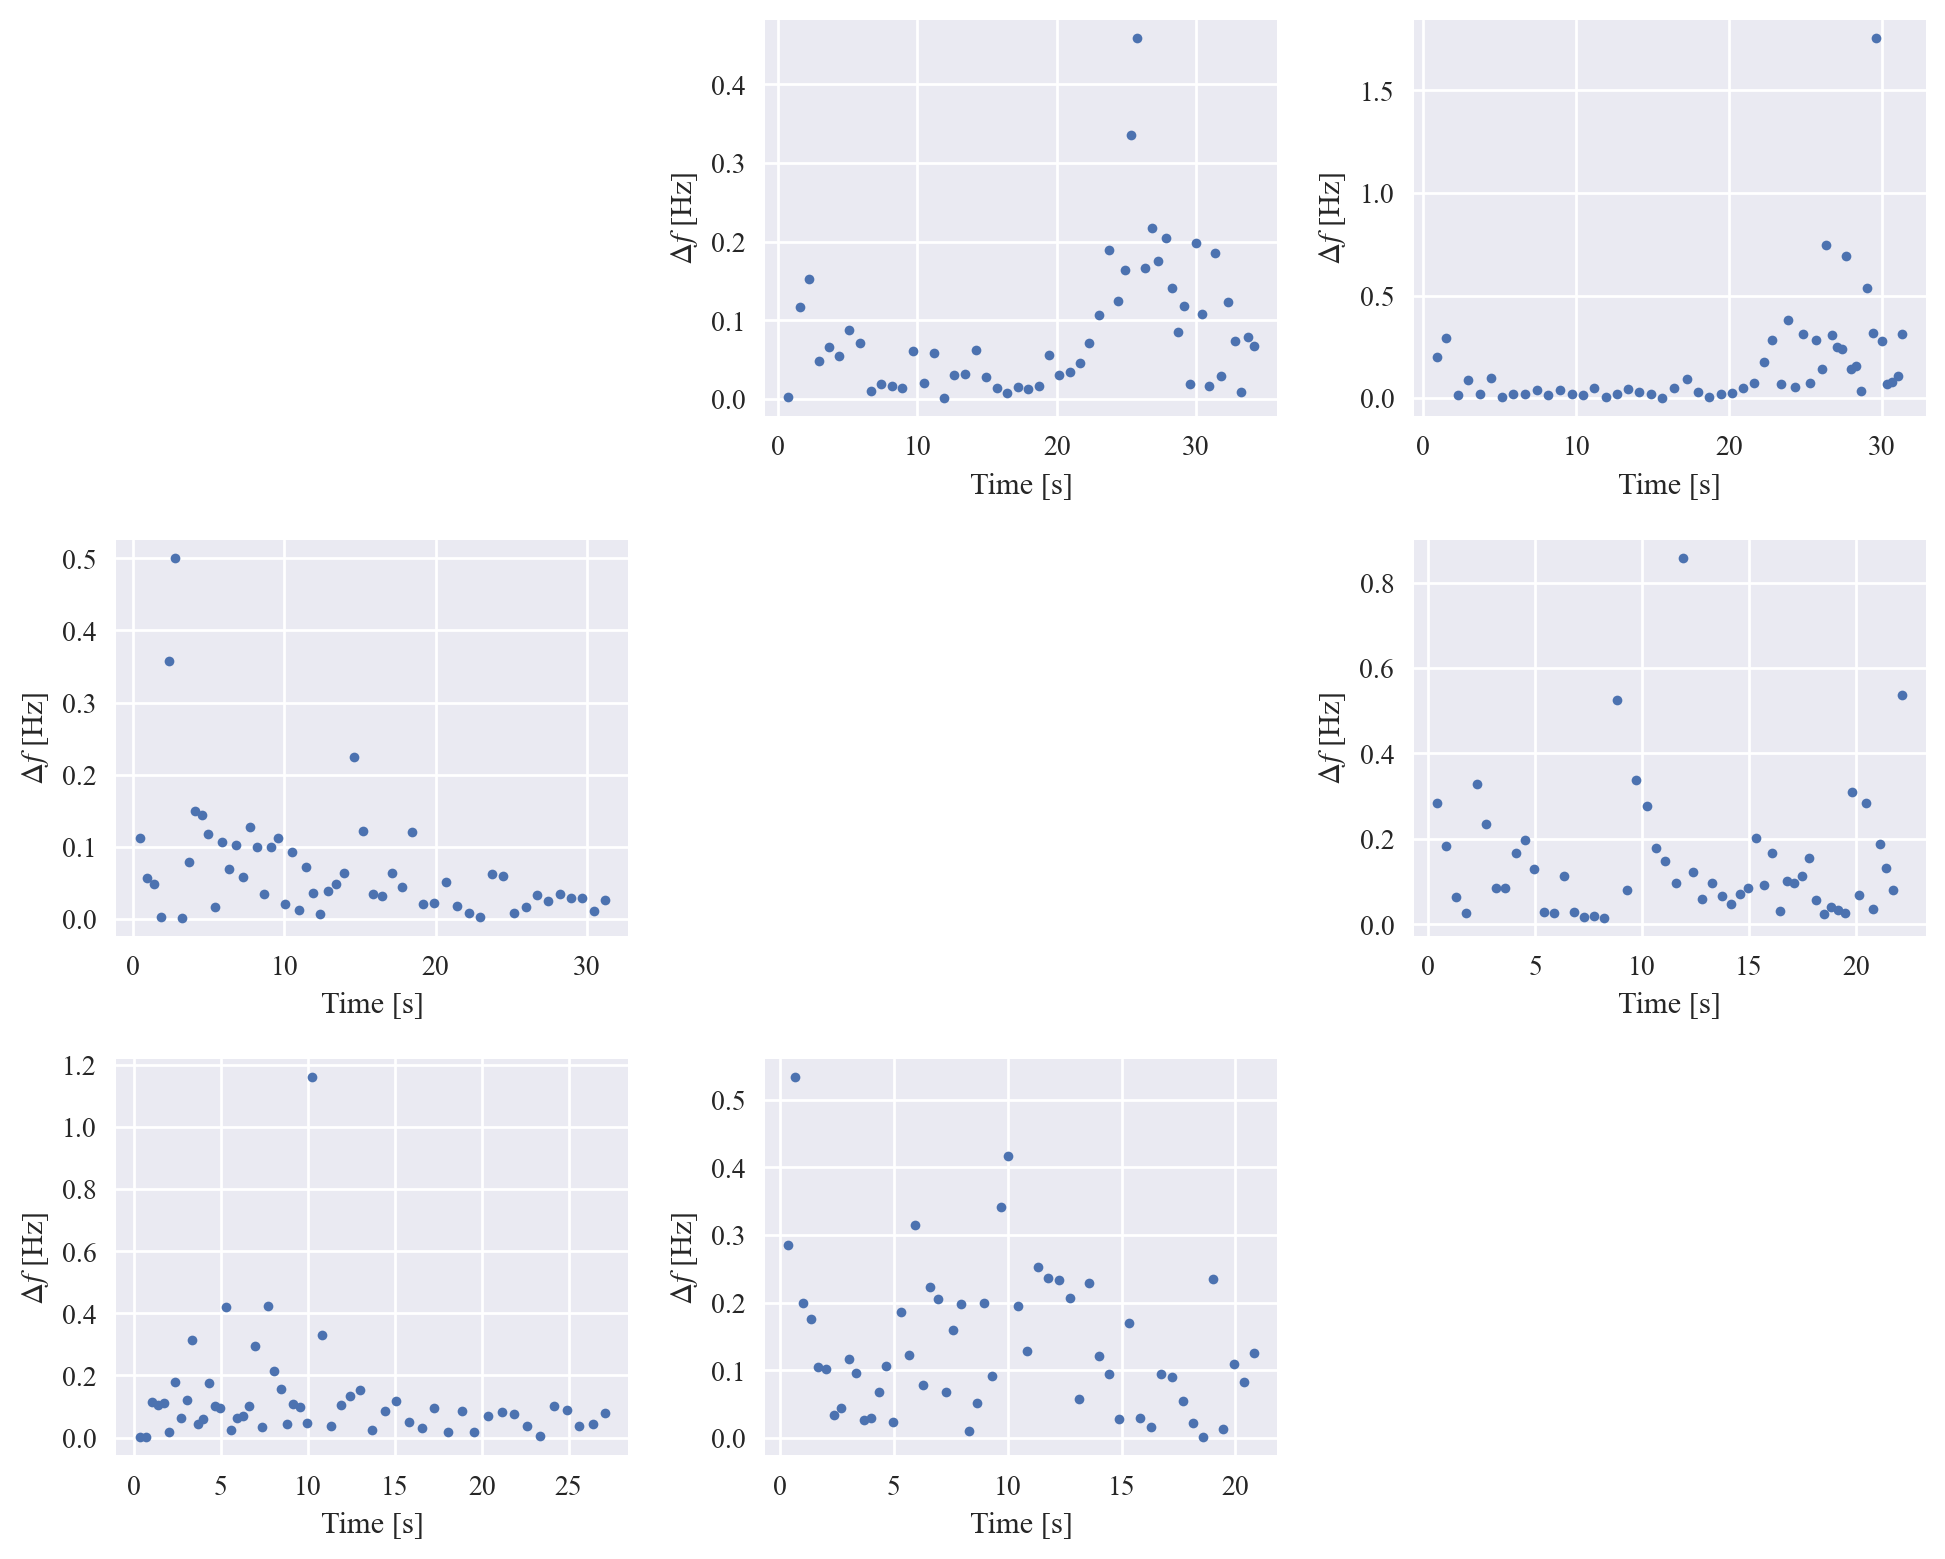

In [114]:
fam_met_dev = []
for i in range(len(fam_list)):
    fam_met_dev.append(np.abs(fam_list[i][2] - fam_list[i][0]))

fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=200)
ax = ax.flatten()

counter = 0

for i in range(len(ax)):
    if i % 4 != 0:
        ax[i].plot(fam_list[counter][3], fam_met_dev[counter], marker='.', ls='')
        ax[i].set(xlabel = ('Time [s]'), ylabel = (r'$\Delta f$ [Hz]'))
        counter += 1
    else: 
        ax[i].set_visible(False)

fig.tight_layout()


____

## Analyse af Gefiondata med $prominence = 0.07$ 

In [115]:
gefion_3y_extensions = ['3y/', 9]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

gefion_3y_exp_data = experiment_data_ext(gefion_3y_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# avg_freq, freq_err, f_met, x, t_exp, s_exp, pt_exp, p_exp, pt_met, p_met


(25.0, 32.0)

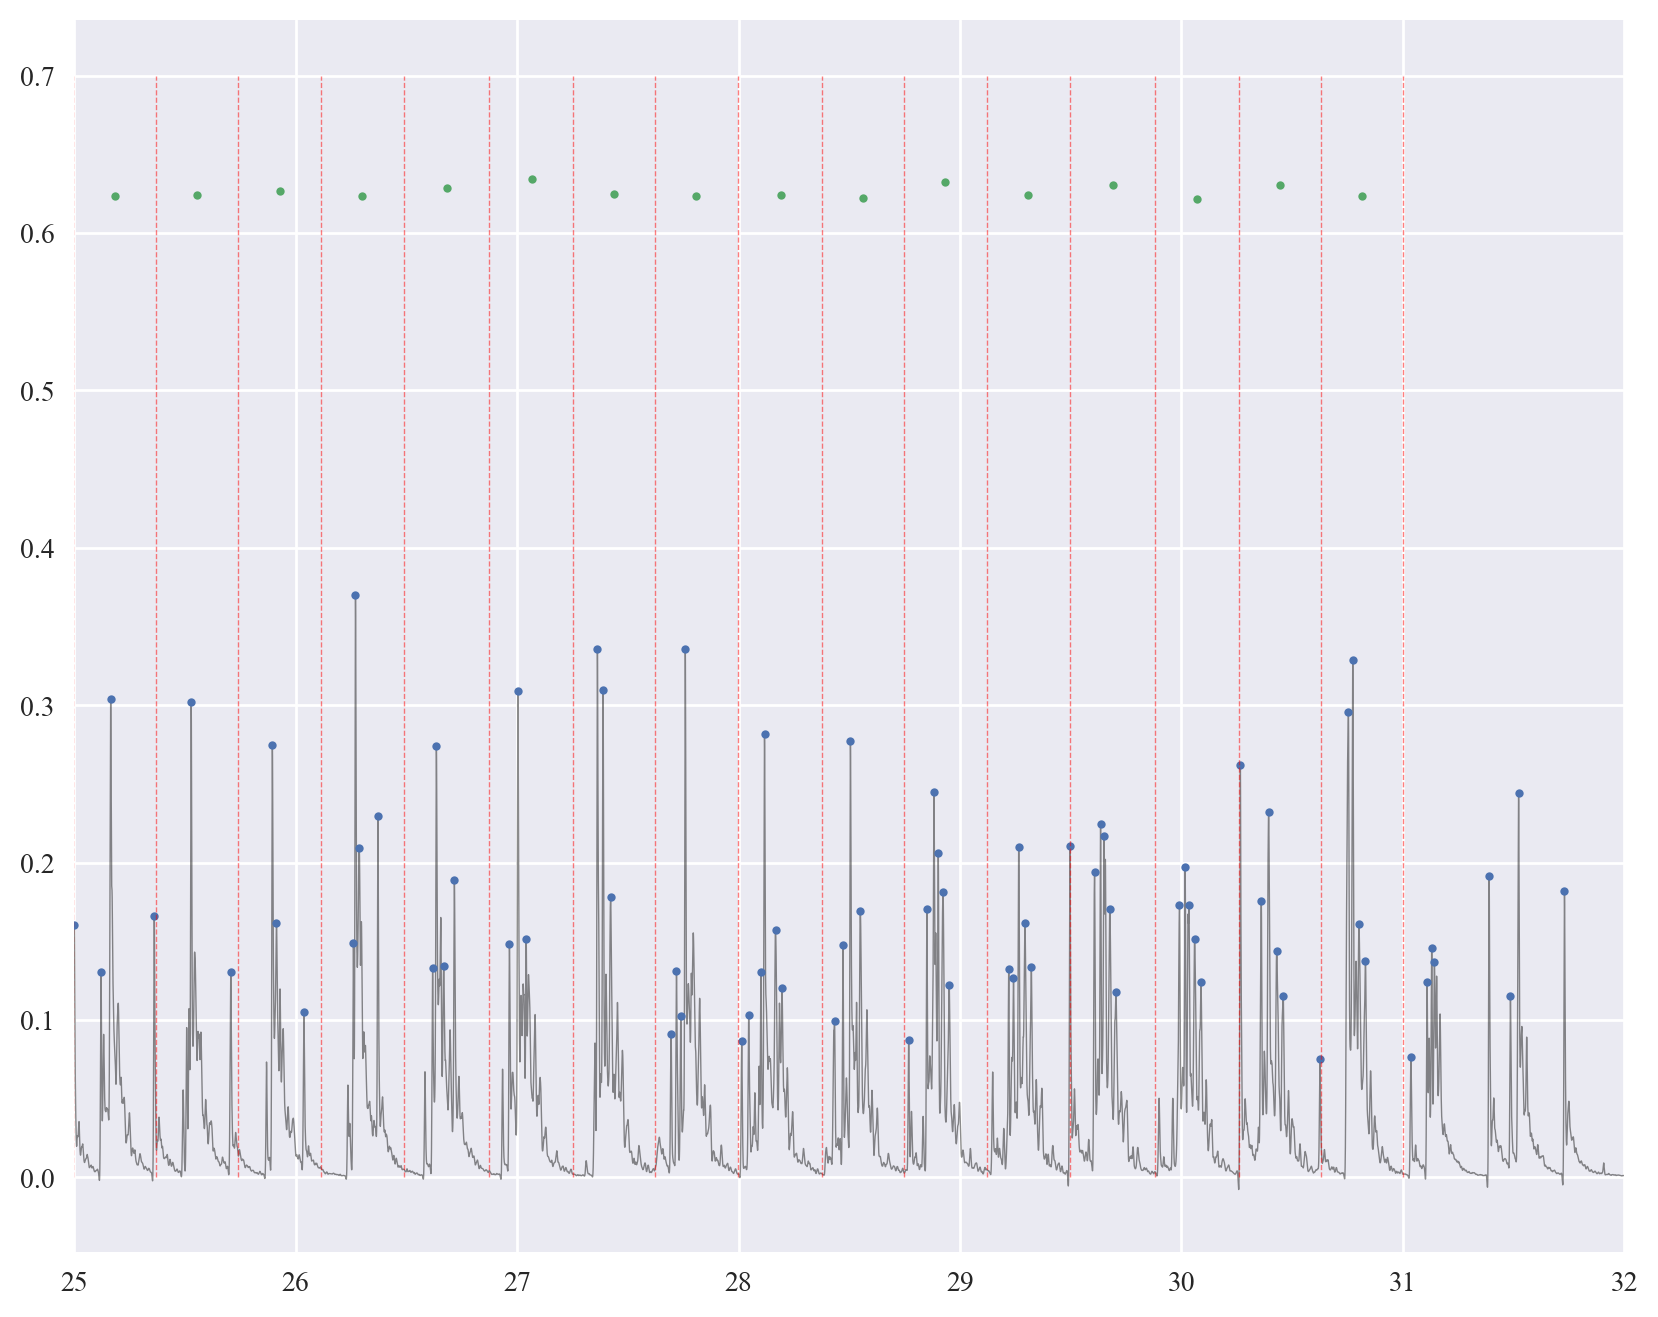

In [116]:
# Plot index 1 (LH) of the experiment data
fig, ax = plt.subplots(figsize=(10,8), dpi=200)
ax.plot(gefion_3y_exp_data[3][4], gefion_3y_exp_data[3][5], marker='', ls='-', linewidth=0.5, color='k', alpha=0.5)
ax.plot(gefion_3y_exp_data[3][6], gefion_3y_exp_data[3][7], marker = 'o', markersize = 3, ls = '')
# Plot metronone peak times
ax.plot(gefion_3y_exp_data[3][8], gefion_3y_exp_data[3][9], marker='o', markersize=3, ls='')

mh_pt_met = gefion_3y_exp_data[3][8]
bin_edges = (mh_pt_met[:-1] + mh_pt_met[1:])/2
start_diff = bin_edges[1] - bin_edges[0]
end_diff = bin_edges[-1] - bin_edges[-2]
bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))

ax.vlines(bin_edges, 0, 0.7, ls='--', color='red', alpha=0.5, linewidth=0.5)
ax.set_xlim(25, 32)


In [117]:
# fig, ax = exp_data_plot_func(gefion_3y_exp_data)
#fig.savefig('3y_gefion_n9.png')

In [118]:
dev_dict = {}
dev_dict['dev_tuple_3y_n9'] = deviation_func(gefion_3y_exp_data, 24, 40)
# fig_dev, ax_dev = deviation_plot(gefion_3y_exp_data, dev_dict['dev_tuple_3y_n9'], )
# fig_dev.savefig('3y_gefion_n9_dev.png')

# fig_time_dev, ax_time_dev = time_deviation_plot(gefion_3y_exp_data, dev_dict['dev_tuple_3y_n9'])

In [119]:
met_mid_low_us = read_wave('lydfiler/metronomfiler/mid_low_inc_thres.wav', resolution=np.int16)

met_mid_low_filt = lp_filter(met_mid_low_us[0], cutoff_frequency=100)

# fig, ax = plt.subplots(1,1, dpi=100, figsize=(10,8))
# ax.set(xlim=(9.8,9.9))
# ax.plot(met_mid_low_us[2], met_mid_low_us[0], color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Unfiltered signal')
# ax.plot(met_mid_low_us[2], met_mid_low_filt, color='red', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='Filtered signal')

In [120]:
gefion_3p_n7_1_extensions = ['3p/n7_1/', 7]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

gefion_3p_n7_1_data = experiment_data_ext(gefion_3p_n7_1_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig, ax = exp_data_plot_func(gefion_3p_n7_1_data)

In [121]:
dev_dict['dev_tuple_3p_n7_1'] = deviation_func(gefion_3p_n7_1_data, 24, 40)
# fig_dev, ax_dev = deviation_plot(gefion_3p_n7_1_data, dev_dict['dev_tuple_3p_n7_1'])
# fig_time_dev_n7_1, ax_time_dev_n7_1 = time_deviation_plot(gefion_3p_n7_1_data, dev_dict['dev_tuple_3p_n7_1'])

In [122]:
gefion_3p_n7_2_extensions = ['3p/n7_2/', 7]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

gefion_3p_n7_2_data = experiment_data_ext(gefion_3p_n7_2_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
#fig, ax = exp_data_plot_func(gefion_3p_n7_2_data)

In [123]:
dev_dict['dev_tuple_3p_n8_2'] = deviation_func(gefion_3p_n7_2_data, 24, 40)

# fig_dev, ax_dev = deviation_plot(gefion_3p_n7_2_data, dev_dict['dev_tuple_3p_n8_2'])
# fig_dev.suptitle('Gefion 3.p, n=7, andet forsøg')
# fig_time_dev_n7_2, ax_time_dev_n7_2 = time_deviation_plot(gefion_3p_n7_2_data, dev_dict['dev_tuple_3p_n8_2'])

In [124]:
gefion_3p_n11_extensions = ['3p/n11/', 11]
resolution = (np.int16, np.int16)
cutoff_freq = (100, 100)

gefion_3p_n11_data = experiment_data_ext(gefion_3p_n11_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig, ax = exp_data_plot_func(gefion_3p_n11_data)


In [125]:
dev_dict['dev_tuple_3p_n11'] = deviation_func(gefion_3p_n11_data, 24, 40)

# fig_dev, ax_dev = deviation_plot(gefion_3p_n11_data, dev_dict['dev_tuple_3p_n11'])
# fig_time_dev_n11, ax_time_dev_n11 = time_deviation_plot(gefion_3p_n11_data, dev_dict['dev_tuple_3p_n11'])

In [126]:
gefion_n22_extensions = ['n22/', 22]
gefion_n22_data = experiment_data_ext(gefion_n22_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n22, ax_n22 = exp_data_plot_func(gefion_n22_data)

In [127]:
dev_dict['dev_tuple_n22'] = deviation_func(gefion_n22_data, 24, 40)

# fig_dev_n22, ax_dev_n22 = deviation_plot(gefion_n22_data, dev_dict['dev_tuple_n22'])
# fig_time_dev_n22, ax_time_dev_22 = time_deviation_plot(gefion_n22_data, dev_dict['dev_tuple_n22'])

In [128]:
gefion_n25_extensions = ['n25/', 25]
gefion_n25_data = experiment_data_ext(gefion_n25_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n25, ax_n25 = exp_data_plot_func(gefion_n25_data)

In [129]:
dev_dict['dev_tuple_n25'] = deviation_func(gefion_n25_data, 24, 40)

# fig_dev_n25, ax_dev_n25 = deviation_plot(gefion_n25_data, dev_dict['dev_tuple_n25'])
# fig_time_dev_n25, ax_time_dev_25 = time_deviation_plot(gefion_n25_data, dev_dict['dev_tuple_n25'])

_____

## Load af efterskoledata med $prominence = 0.01$ 


In [130]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Height and prominence for experiment
height_exp = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
prom_exp = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02]

In [131]:
efterskole_n5_extensions = ['efterskole/', 5]
efterskole_n5_data = experiment_data_ext(efterskole_n5_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n5, ax_n5 = exp_data_plot_func(efterskole_n5_data)

In [132]:
# dev_dict['dev_tuble_n5'] = deviation_func(efterskole_n5_data, 24, 40)
# fig_dev_n5, ax_dev_n5 = deviation_plot(efterskole_n5_data, dev_dict['dev_tuble_n5'])
# fig_time_dev_n5, ax_time_dev_5 = time_deviation_plot(efterskole_n5_data, dev_dict['dev_tuble_n5'])

_ _ _ _ _ 

### Resolving issues

In [133]:
efterskole_ml = data_extract_lp('lydfiler/efterskole/ml_n5.wav', 
                               resolution=np.int16, 
                               cutoff_frequency=100, 
                               height_var=0.01,
                               prominence_var=0.02)

met_efterskole_ml = data_extract_lp('lydfiler/metronomfiler/mid_low_inc_thres.wav', 
                                resolution=np.int32, 
                                cutoff_frequency=100, 
                                height_var=0.07,
                                prominence_var=0.3)


met_efterskole_ml, efterskole_ml = synchro(met_efterskole_ml, efterskole_ml)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_efterskole_ml
t_efterskole, s_efterskole, pt_efterskole, p_efterskole, ft_efterskole, f_efterskole = efterskole_ml

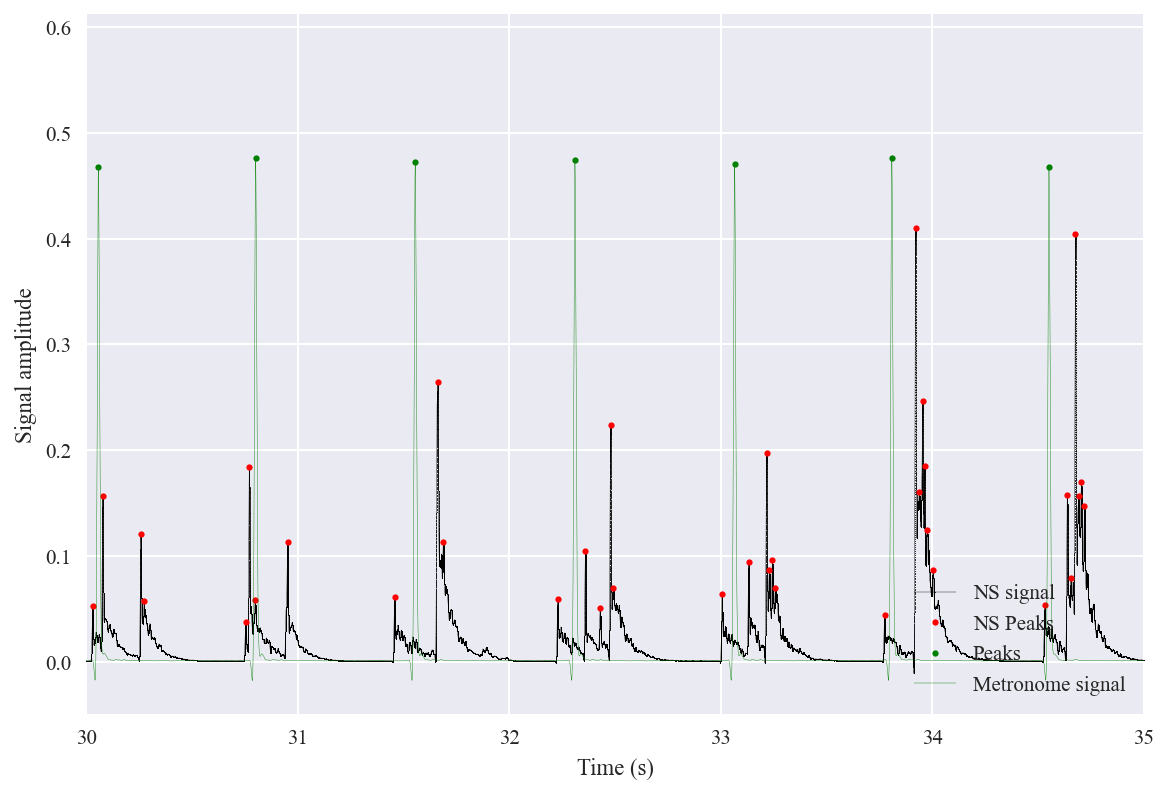

In [134]:
fig, ax = plt.subplots(dpi=150)

ax.plot(t_efterskole, s_efterskole, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax.plot(pt_efterskole, p_efterskole, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
ax.plot(pt_met, p_met, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax.plot(t_met, s_met, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax.legend(loc='lower right')
#ax.set_xlim(0, 2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
ax.set_xlim(30,35)

fig.tight_layout()

____

## Fysikvenner clapping

In [135]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

In [136]:
n4_extensions = ['fysikvenner/', 4]
n4_data = experiment_data_ext(n4_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig_n4, ax_n4 = exp_data_plot_func(n4_data)

In [137]:
dev_dict['dev_tuple_n4'] = deviation_func(n4_data, 24, 40)
# fig_dev_n4, ax_dev_n4 = deviation_plot(n4_data, dev_dict['dev_tuple_n4'])
# fig_time_dev_n4, ax_time_dev_4 = time_deviation_plot(n4_data, dev_dict['dev_tuple_n4'])

In [138]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

In [139]:
n6_extensions = ['andenårs/', 6]
n6_data = experiment_data_ext(n6_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)
# fig_n6, ax_n6 = exp_data_plot_func(n6_data)

In [140]:
dev_dict['dev_tuple_n6'] = deviation_func(n6_data, 24, 40)
# fig_dev_n6, ax_dev_n6 = deviation_plot(n6_data, dev_dict['dev_tuple_n6'])
# fig_time_dev_n6, ax_time_dev_6 = time_deviation_plot(n6_data, dev_dict['dev_tuple_n6'])

In [141]:
n16_extensions = ['mekrel/', 16]

# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]


n16_data = experiment_data_ext(n16_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n16, ax_n16 = exp_data_plot_func(n16_data)

In [142]:
dev_dict['dev_tuple_n16'] = deviation_func(n16_data, 24, 40)
# fig_time_dev_n16, ax_time_dev_16 = time_deviation_plot(n16_data, dev_dict['dev_tuple_n16'])

In [143]:
# Height and prominence for metronome
height_met = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
prom_met = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3]

# Height and prominence for experiment
height_exp = [0.025, 0.025, 0.025, 0.025, 0.025, 0.025]
prom_exp = [0.07, 0.07, 0.07, 0.07, 0.07, 0.07]

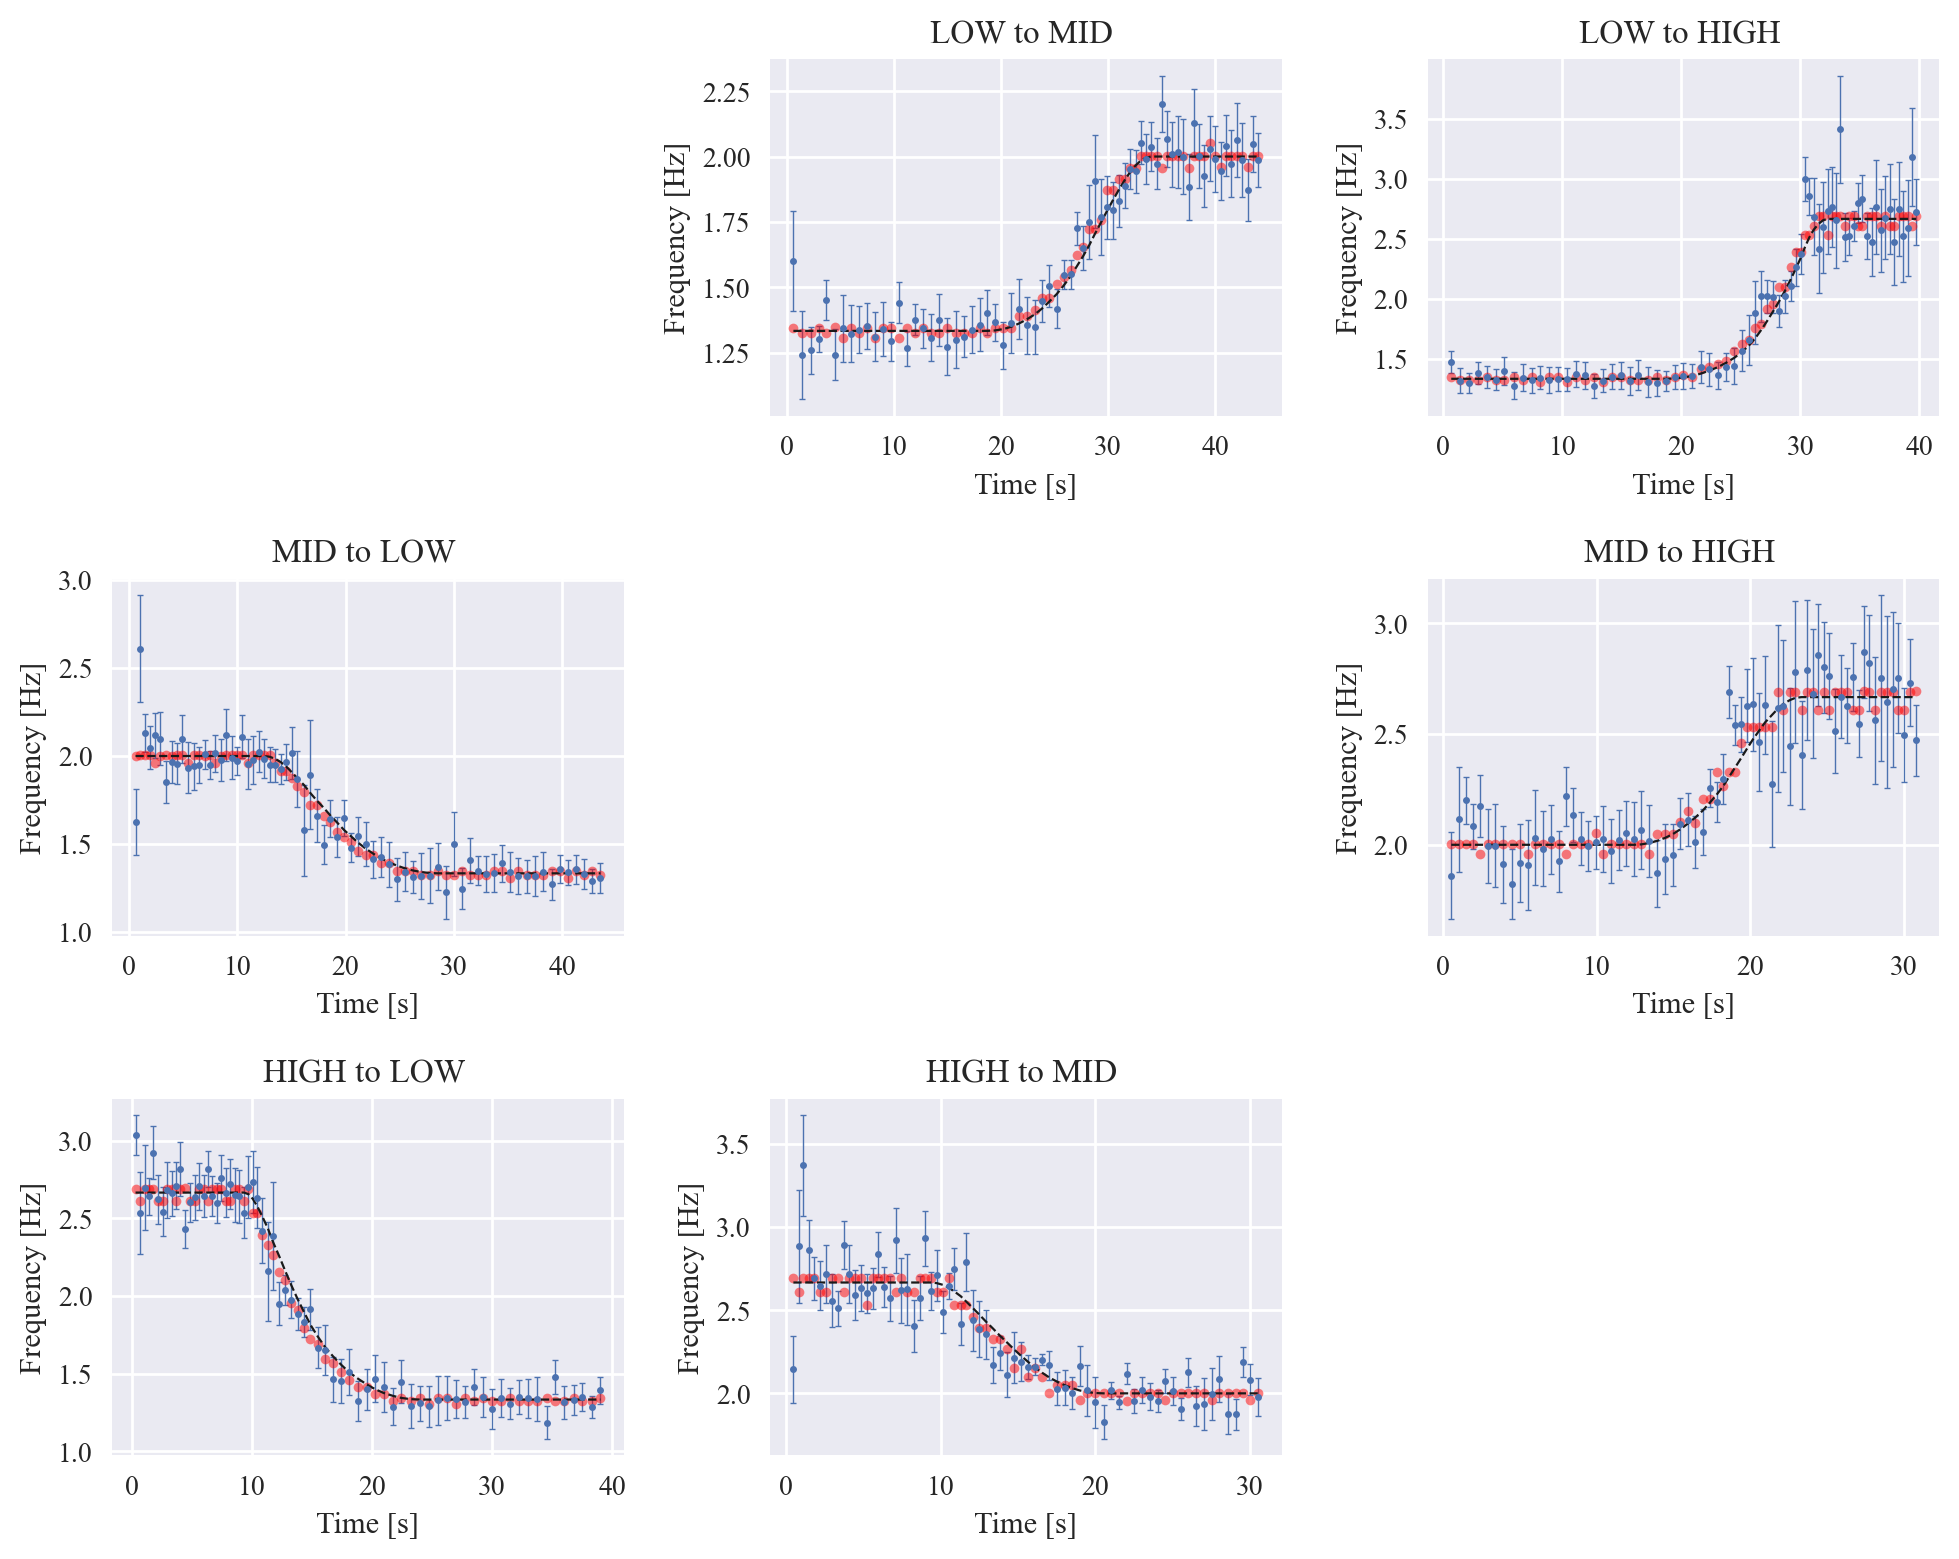

In [ ]:
n44_extensions = ['n44/', 44]
n44_data = experiment_data_ext(n44_extensions, resolution, cutoff_freq, height_met, height_exp, prom_met, prom_exp)

# fig_n44, ax_n44 = exp_data_plot_func(n44_data)

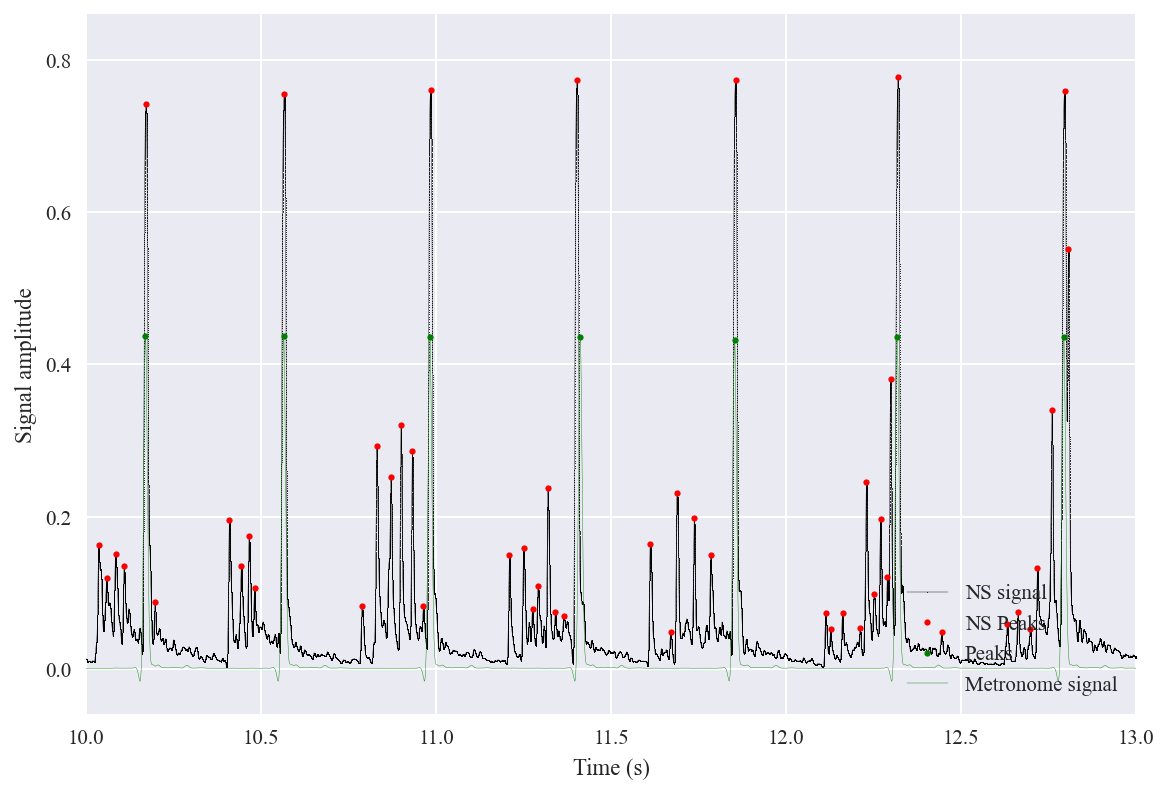

In [145]:
n44_hl = data_extract_lp('lydfiler/n44/hl_n44.wav',
                                 resolution=np.int16, 
                                 cutoff_frequency=100, 
                                 height_var=0.025,
                                 prominence_var=0.03)

met_n44_hl = data_extract_lp('lydfiler/metronomfiler/high_low_inc_thres.wav',
                                    resolution=np.int32, 
                                    cutoff_frequency=100, 
                                    height_var=0.07,
                                    prominence_var=0.3)

met_n44_hl, n44_hl = synchro(met_n44_hl, n44_hl)

t_met, s_met, pt_met, p_met, ft_met, f_met = met_n44_hl

t_n44, s_n44, pt_n44, p_n44, ft_n44, f_n44 = n44_hl

fig, ax = plt.subplots(dpi=150)

ax.plot(t_n44, s_n44, color='black', ls='-', marker='.', linewidth = 0.2, markersize=0.8, label='NS signal')
ax.plot(pt_n44, p_n44, color='red', ls='', marker='o', markersize=3, label='NS Peaks')
ax.plot(pt_met, p_met, color='green', ls='', marker='o', markersize=3, label='Peaks')
ax.plot(t_met, s_met, color='green', ls='-', linewidth = 0.2, label='Metronome signal')
ax.legend(loc='lower right')
#ax.set_xlim(0, 2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal amplitude')
ax.set_xlim(10,13)

fig.tight_layout()


In [146]:
dev_dict['dev_tuple_n44'] = deviation_func(n44_data, 24, 40)

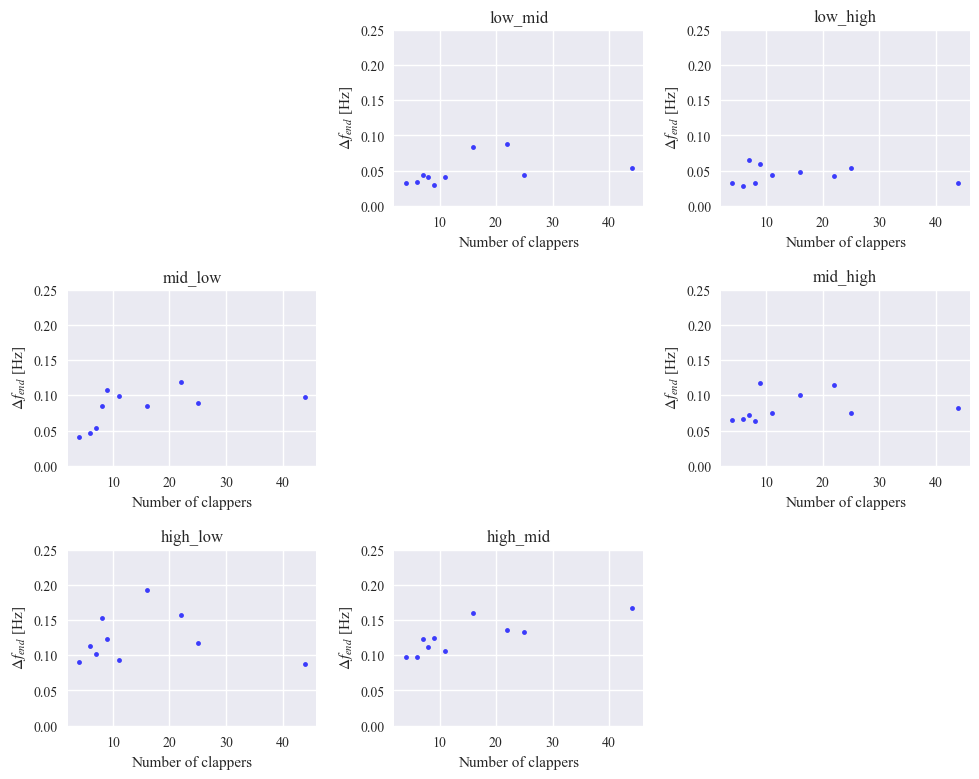

In [147]:
import re

def dev_n_plot(dev_dict):
    n_list = []
    dev_start_list = [[] for i in range(6)]
    dev_trans_list = [[] for i in range(6)]
    dev_end_list = [[] for i in range(6)]

    for key in dev_dict.keys():
        regex = re.compile(r'n[0-9]+')
        match = regex.findall(key)
        n = int(match[0][1:])
        n_list.append(n)

        for i in range(6):
            dev_start_list[i].append(dev_dict[key][1][i])
            dev_trans_list[i].append(dev_dict[key][2][i])
            dev_end_list[i].append(dev_dict[key][3][i])

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=100)

    ax = ax.flatten()

    counter = 0

    for i in range(len(ax)):
        if i % 4 != 0:
            ax[i].plot(n_list, dev_start_list[counter], marker='.', ls='', label = 'Initial period deviation', color='blue', alpha = 0.75)
            ax[i].set(ylim=(0, 0.25))
            #ax[i].plot(n_list, dev_trans_list[counter], marker='.', ls='', label = 'Transition period deviation', color='green')
            #ax[i].plot(n_list, dev_end_list[counter], marker='.', ls='', label = 'End period deviation', color='red')

            ax[i].set(xlabel = ('Number of clappers'), ylabel = (r'$\Delta f_{end}$ [Hz]'))
            ax[i].set_title(met_filenames[counter])
            #ax[i].legend()

            counter += 1

        else:
            ax[i].set_visible(False)

    fig.tight_layout()

    return fig, ax


def dev_n_t_plot(dev_dict): 
    n_list = []
    dev_start_list = [[] for i in range(6)]
    dev_trans_list = [[] for i in range(6)]
    dev_end_list = [[] for i in range(6)]

    for key in dev_dict.keys():
        regex = re.compile(r'n[0-9]+')
        match = regex.findall(key)
        n = int(match[0][1:])
        n_list.append(n)

        for i in range(6):
            dev_start_list[i].append(dev_dict[key][5][i])
            dev_trans_list[i].append(dev_dict[key][6][i])
            dev_end_list[i].append(dev_dict[key][7][i])

    fig, ax = plt.subplots(3,3, figsize=(10,8), dpi=100)

    ax = ax.flatten()

    counter = 0

    for i in range(len(ax)):
        if i % 4 != 0:
            #ax[i].plot(n_list, dev_start_list[counter], marker='.', ls='', label = 'Initial period deviation', color='blue', alpha = 0.75)
            #ax[i].set(ylim=(0, 0.25))
            ax[i].plot(n_list, dev_trans_list[counter], marker='.', ls='', label = 'Transition period deviation', color='green')
            #ax[i].plot(n_list, dev_end_list[counter], marker='.', ls='', label = 'End period deviation', color='red')

            ax[i].set(xlabel = ('Number of clappers'), ylabel = (r'$\Delta t_{end}$ [s]'))
            ax[i].set_title(met_filenames[counter])
            #ax[i].legend()

            counter += 1

        else:
            ax[i].set_visible(False)

    fig.tight_layout()

    return fig, ax

fig, ax = dev_n_plot(dev_dict)
fig.savefig('start_dev_n_plot.png', dpi=200)

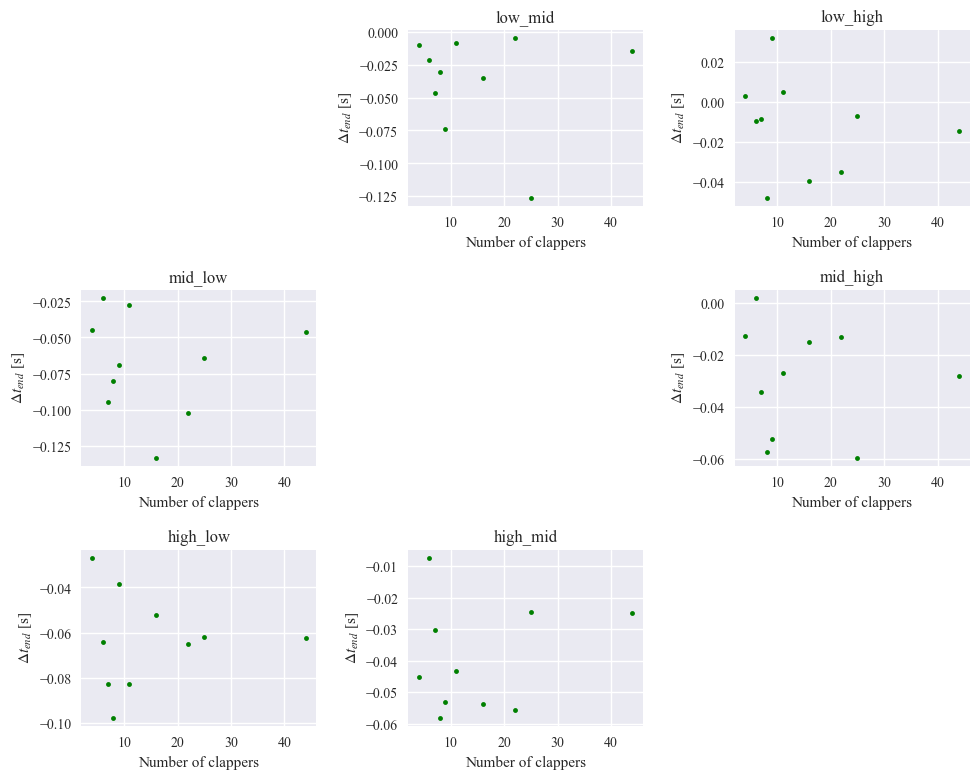

In [148]:
fig, ax = dev_n_t_plot(dev_dict)

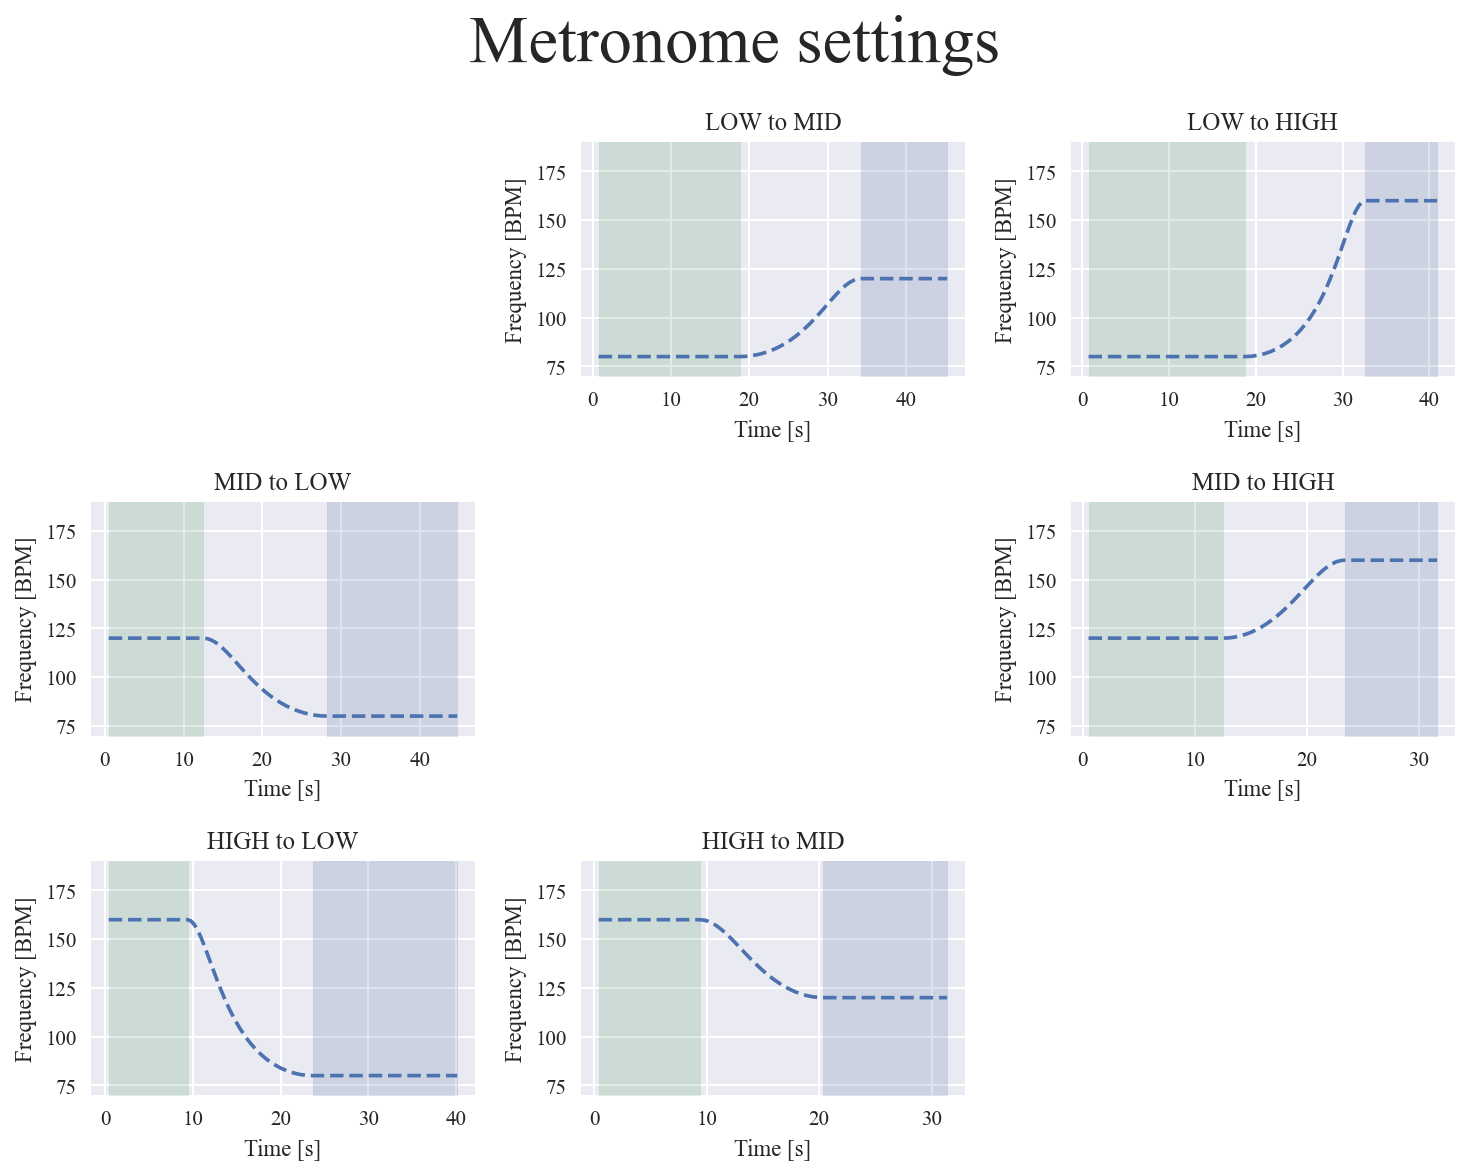

In [163]:
# Plotting the sigmoid function for each setting

fig_sig, ax_sig = plt.subplots(3,3, figsize=(10,8), dpi=150)
ax_sig = ax_sig.flatten()

bpm_tuples = [(80, 120), (80, 160), (120, 80), (120, 160), (160, 80), (160, 120)]


counter = 0
for i in range(len(ax_sig)):
    if i % 4 != 0:
        sig_x = np.linspace(0, 40, 72)
        p_list = p_func(sig_x, threshold_l = 24, threshold_h = 48)
        sig_y = 60 / interval_calc(*bpm_tuples[counter], p_list)
        cum_int = np.cumsum(interval_calc(*bpm_tuples[counter], p_list))
        ax_sig[i].plot(cum_int, sig_y, marker='', ls='--', label='Sigmoid for bpm = {}'.format(bpm_tuples[counter]))
        ax_sig[i].set(xlabel = ('Time [s]'), ylabel = ('Frequency [BPM]'))

        diff = abs(np.diff(sig_y))
        trans_start = np.where(diff > 0)[0][0] 
        trans_end = np.where(diff > 0)[0][-1]
        init = bpm_tuples[counter][0]
        final = bpm_tuples[counter][1]
        sorted = np.sort(bpm_tuples[counter])

        # color start and end preiods
        ax_sig[i].fill_between((cum_int[0], cum_int[trans_start]), -10, 200, color=colors[6], alpha=0.2)
        ax_sig[i].fill_between((cum_int[trans_end + 1], cum_int[-1]), -10, 200, color=colors[8], alpha=0.2)
       
        ax_sig[i].set_ylim(70, 190)


        if init == 80 and final == 120:
            ax_sig[i].set_title('LOW to MID')
        elif init == 80 and final == 160:
            ax_sig[i].set_title('LOW to HIGH')
        elif init == 120 and final == 80:
            ax_sig[i].set_title('MID to LOW')
        elif init == 120 and final == 160:
            ax_sig[i].set_title('MID to HIGH')
        elif init == 160 and final == 80:
            ax_sig[i].set_title('HIGH to LOW')
        else:
            ax_sig[i].set_title('HIGH to MID')
        
        counter += 1


    else: 
        ax_sig[i].set_visible(False)

fig_sig.suptitle('Metronome settings', fontsize=32)
fig_sig.tight_layout()

fig_sig.savefig('figurer/rapport/metronome_settings.png')
